In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## iCESM Pi Control TAGGED d18O field vs. SAM, PSA1, PSA2, EPC1, EPC2, SOI, Nino34, ASL CP Long. Position, and ASL CP Value

## Also, Include Quartile Differences in d18O Contributions from Tagged Regions to psuedoWDC d18O Record during Positive vs. Negative Indices

### Plot 5x1 (DJF, MAM, JJA, SON, ANN)
### no rolls (for some reason some are blank due to a unknown mask error)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_Submission_30Apr2020'

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA_TAGGED.nc')
CTRL_DATA

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    tp            (time, lat, lon) float32 ...
    ci            (time, lat, lon) float32 ...
    d18O          (time, lat, lon) float32 ...
    d18O_Atl_05   (time, lat, lon) float32 ...
    d18O_Atl_15   (time, lat, lon) float32 ...
    d18O_Atl_25   (time, lat, lon) float32 ...
    d18O_Atl_35   (time, lat, lon) float32 ...
    d18O_Atl_45   (time, lat, lon) float32 ...
    d18O_

In [4]:
#getting variables in right units 
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

In [5]:
#sst_tmon_ctrl

In [6]:
#Open pandas dfs of all indices and ASL information
pdo_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_tmon.pkl')
# pdo_index_ctrl.head(n=5)
pdo_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_seas.pkl')
# pdo_seas_mean_index_ctrl.head(n=5)
pdo_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_ann_mean.pkl')
# pdo_ann_mean_index_ctrl.head(n=5)

soi_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_tmon.pkl')
# soi_index_ctrl.head(n=5)
soi_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_seas.pkl')
# soi_seas_mean_index_ctrl.head(n=5)
soi_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_ann_mean.pkl')
# soi_ann_mean_index_ctrl.head(n=5)
soi_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_12roll_mean.pkl')
# soi_12roll_mean_index_ctrl.head(n=10)
soi_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_6roll_mean.pkl')
# soi_6roll_mean_index_ctrl.head(n=5)
soi_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_3roll_mean.pkl')
# soi_3roll_mean_index_ctrl.head(n=5)
soi_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_band_filt.pkl')
# soi_band_filt_index_ctrl.head(n=5)

nino34_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_tmon.pkl')
# nino34_index_ctrl.head(n=5)
nino34_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_seas.pkl')
# nino34_seas_mean_index_ctrl.head(n=5)
nino34_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_ann_mean.pkl')
# nino34_ann_mean_index_ctrl.head(n=5)
nino34_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_12roll_mean.pkl')
# nino34_12roll_mean_index_ctrl.head(n=10)
nino34_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_6roll_mean.pkl')
# nino34_6roll_mean_index_ctrl.head(n=5)
nino34_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_3roll_mean.pkl')
# nino34_3roll_mean_index_ctrl.head(n=5)
nino34_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_band_filt.pkl')
# nino34_band_filt_index_ctrl.head(n=5)

enso_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_tmon.pkl')
# enso_indices_ctrl.head(n=5)
enso_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_seas.pkl')
# enso_seas_mean_indices_ctrl.head(n=5)
enso_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_ann_mean.pkl')
# enso_ann_mean_indices_ctrl.head(n=5)
enso_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_12roll_mean.pkl')
# enso_12roll_mean_indices_ctrl.head(n=10)
enso_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_6roll_mean.pkl')
# enso_6roll_mean_indices_ctrl.head(n=5)
enso_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_3roll_mean.pkl')
# enso_3roll_mean_indices_ctrl.head(n=5)
enso_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_band_filt.pkl')
# enso_band_filt_indices_ctrl.head(n=5)

SAM_PSAs_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_tmon.pkl')
# SAM_PSAs_indices_ctrl.head(n=5)
SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_ctrl.head(n=5)
SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))
SAM_PSAs_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_ctrl.head(n=10)
SAM_PSAs_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_ctrl.head(n=5)

df_d18O_psuedoWDC_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_tmon.pkl')
# df_d18O_psuedoWDC_tmon_ctrl.head(n=5)
d18O_psuedoWDC_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_seas.pkl')
# d18O_psuedoWDC_seas_mean_ctrl.head(n=5)
d18O_psuedoWDC_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_ann_mean.pkl')
# d18O_psuedoWDC_ann_mean_ctrl.head(n=5)
d18O_psuedoWDC_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_12roll_mean.pkl')
# d18O_psuedoWDC_12roll_mean_ctrl.head(n=10)
d18O_psuedoWDC_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_6roll_mean.pkl')
# d18O_psuedoWDC_6roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_3roll_mean.pkl')
# d18O_psuedoWDC_3roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_band_filt.pkl')
# d18O_psuedoWDC_band_filt_ctrl.head(n=5)

# df_d18O_psuedowestcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_ctrl.head(n=5)
# d18O_psuedowestcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_ctrl.head(n=5)
# d18O_psuedowestcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_ctrl.head(n=5)
# d18O_psuedowestcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedowestcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_ctrl.head(n=5)

# df_d18O_psuedoeastcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_ctrl.head(n=5)
# d18O_psuedoeastcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedoeastcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_ctrl.head(n=5)

# d18O_wais_pcs_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_ctrl.head(n=5)
# d18O_wais_pcs_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_ctrl.head(n=5)
# d18O_wais_pcs_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_ctrl.head(n=5)
# d18O_wais_pcs_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_ctrl.head(n=12)
# d18O_wais_pcs_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_ctrl.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Rel_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_ctrl.head(n=5)
# Rel_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_ctrl.head(n=5)
# Rel_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_ctrl.head(n=10)
# Rel_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_ctrl.head(n=5)
# Rel_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_ctrl.head(n=5)
# Rel_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_ctrl.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Abs_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_ctrl.head(n=5)
# Abs_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_ctrl.head(n=5)
# Abs_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_ctrl.head(n=10)
# Abs_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_ctrl.head(n=5)
# Abs_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_ctrl.head(n=5)
# Abs_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_ctrl.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_ctrl_tagged_df.head(n=5)
Rel_CP_djf_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)
Rel_CP_mam_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_ctrl.head(n=5)
Rel_CP_jja_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_ctrl.head(n=5)
Rel_CP_son_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_ctrl.head(n=5)
Rel_CP_ann_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_ann_mean.pkl')
print(Rel_CP_ann_mean_indices_raw_ctrl.head(n=5))
Rel_CP_12roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_12roll_mean.pkl')
# Rel_CP_12roll_mean_indices_raw_ctrl.head(n=10)
Rel_CP_6roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_6roll_mean.pkl')
# Rel_CP_6roll_mean_indices_raw_ctrl.head(n=5)
Rel_CP_3roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_ctrl.head(n=5)
# Rel_CP_band_filt_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_ctrl.head(n=5)


                 SAM      PSA1      PSA2
time                                    
1702-01-01 -0.311936 -0.015404  0.094802
1703-01-01 -0.819279  0.553104  0.060246
1704-01-01 -0.714730  0.496267 -0.208190
1705-01-01 -0.431827  0.106548 -0.660348
1706-01-01  0.391807 -0.572466  0.115213
                vals       lats   lons  sectormean  indice
time                                                      
1702-01-01 -5.477830 -71.052632  197.5  986.772813       0
1703-01-01 -5.095673 -71.052632  195.0  989.296173       1
1704-01-01 -4.715917 -71.052632  205.0  989.053075       2
1705-01-01 -7.214285 -71.052632  205.0  987.087820       3
1706-01-01 -6.000570 -71.052632  207.5  982.878988       4


In [7]:
enso_seas_mean_indices_ctrl.head(n=5)

,EPC1,EPC2,Seas_Index
time,,,
1702-03-01,-0.745216,1.350615,03
1702-06-01,-0.889220,-0.021015,06
1702-09-01,-0.921228,0.465826,09
1702-12-01,-0.279582,1.136990,12
1703-03-01,0.681926,1.932079,03


In [8]:
Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1702-12-01,-4.536918,-69.157895,285.0,991.552848,0
1703-12-01,-4.965650,-65.368421,280.0,991.921216,1
1704-12-01,-3.187957,-65.368421,277.5,993.587920,2
1705-12-01,-3.782043,-65.368421,280.0,988.717834,3
1706-12-01,-4.084033,-65.368421,262.5,989.826160,4


In [9]:
Rel_CP_ann_mean_indices_raw_ctrl.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1702-01-01,-5.477830,-71.052632,197.5,986.772813,0
1703-01-01,-5.095673,-71.052632,195.0,989.296173,1
1704-01-01,-4.715917,-71.052632,205.0,989.053075,2
1705-01-01,-7.214285,-71.052632,205.0,987.087820,3
1706-01-01,-6.000570,-71.052632,207.5,982.878988,4


## Creating the Tagged Regions and Weighting the d18O contribution by the amount of precip

In [10]:
#Tagged Variables in right units
d18O_Atl_05_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_05'] #per mill
d18O_Atl_15_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_15'] #per mill
d18O_Atl_25_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_25'] #per mill
d18O_Atl_35_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_35'] #per mill
d18O_Atl_45_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_45'] #per mill
d18O_Atl_55_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_55'] #per mill
d18O_Atl_65_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_65'] #per mill
d18O_Atl_75_tmon_ctrl = CTRL_DATA.data_vars['d18O_Atl_75'] #per mill
tp_Atl_05_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_05']*60*60*24*1000  #in mm/day  
tp_Atl_15_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_15']*60*60*24*1000  #in mm/day  
tp_Atl_25_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_25']*60*60*24*1000  #in mm/day  
tp_Atl_35_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_35']*60*60*24*1000  #in mm/day  
tp_Atl_45_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_45']*60*60*24*1000  #in mm/day  
tp_Atl_55_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_55']*60*60*24*1000  #in mm/day  
tp_Atl_65_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_65']*60*60*24*1000  #in mm/day  
tp_Atl_75_tmon_ctrl = CTRL_DATA.data_vars['tp_Atl_75']*60*60*24*1000  #in mm/day  
d18O_Pac_05_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_05'] #per mill
d18O_Pac_15_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_15'] #per mill
d18O_Pac_25_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_25'] #per mill
d18O_Pac_35_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_35'] #per mill
d18O_Pac_45_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_45'] #per mill
d18O_Pac_55_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_55'] #per mill
d18O_Pac_65_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_65'] #per mill
d18O_Pac_75_tmon_ctrl = CTRL_DATA.data_vars['d18O_Pac_75'] #per mill
tp_Pac_05_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_05']*60*60*24*1000  #in mm/day  
tp_Pac_15_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_15']*60*60*24*1000  #in mm/day  
tp_Pac_25_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_25']*60*60*24*1000  #in mm/day  
tp_Pac_35_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_35']*60*60*24*1000  #in mm/day  
tp_Pac_45_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_45']*60*60*24*1000  #in mm/day  
tp_Pac_55_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_55']*60*60*24*1000  #in mm/day  
tp_Pac_65_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_65']*60*60*24*1000  #in mm/day  
tp_Pac_75_tmon_ctrl = CTRL_DATA.data_vars['tp_Pac_75']*60*60*24*1000  #in mm/day  
d18O_Ind_05_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_05'] #per mill
d18O_Ind_15_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_15'] #per mill
d18O_Ind_25_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_25'] #per mill
d18O_Ind_35_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_35'] #per mill
d18O_Ind_45_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_45'] #per mill
d18O_Ind_55_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_55'] #per mill
d18O_Ind_65_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_65'] #per mill
d18O_Ind_75_tmon_ctrl = CTRL_DATA.data_vars['d18O_Ind_75'] #per mill
tp_Ind_05_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_05']*60*60*24*1000  #in mm/day  
tp_Ind_15_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_15']*60*60*24*1000  #in mm/day  
tp_Ind_25_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_25']*60*60*24*1000  #in mm/day  
tp_Ind_35_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_35']*60*60*24*1000  #in mm/day  
tp_Ind_45_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_45']*60*60*24*1000  #in mm/day  
tp_Ind_55_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_55']*60*60*24*1000  #in mm/day  
tp_Ind_65_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_65']*60*60*24*1000  #in mm/day  
tp_Ind_75_tmon_ctrl = CTRL_DATA.data_vars['tp_Ind_75']*60*60*24*1000  #in mm/day  
d18O_AA_ice_tmon_ctrl = CTRL_DATA.data_vars['d18O_AA_ice'] #per mill
d18O_AA_land_tmon_ctrl = CTRL_DATA.data_vars['d18O_AA_land'] #per mill
tp_AA_ice_tmon_ctrl = CTRL_DATA.data_vars['tp_AA_ice']*60*60*24*1000  #in mm/day  
tp_AA_land_tmon_ctrl = CTRL_DATA.data_vars['tp_AA_land']*60*60*24*1000  #in mm/day  

In [11]:
#Weight d18O signal by precipitation from tagged region w.r.t. total precipition
#Atlantic weighted d18O
d18O_Atl_05_weighted_tmon_ctrl = d18O_Atl_05_tmon_ctrl*(tp_Atl_05_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_15_weighted_tmon_ctrl = d18O_Atl_15_tmon_ctrl*(tp_Atl_15_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_25_weighted_tmon_ctrl = d18O_Atl_25_tmon_ctrl*(tp_Atl_25_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_35_weighted_tmon_ctrl = d18O_Atl_35_tmon_ctrl*(tp_Atl_35_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_45_weighted_tmon_ctrl = d18O_Atl_45_tmon_ctrl*(tp_Atl_45_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_55_weighted_tmon_ctrl = d18O_Atl_55_tmon_ctrl*(tp_Atl_55_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_65_weighted_tmon_ctrl = d18O_Atl_65_tmon_ctrl*(tp_Atl_65_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Atl_75_weighted_tmon_ctrl = d18O_Atl_75_tmon_ctrl*(tp_Atl_75_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Pacific weighted d18O
d18O_Pac_05_weighted_tmon_ctrl = d18O_Pac_05_tmon_ctrl*(tp_Pac_05_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_15_weighted_tmon_ctrl = d18O_Pac_15_tmon_ctrl*(tp_Pac_15_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_25_weighted_tmon_ctrl = d18O_Pac_25_tmon_ctrl*(tp_Pac_25_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_35_weighted_tmon_ctrl = d18O_Pac_35_tmon_ctrl*(tp_Pac_35_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_45_weighted_tmon_ctrl = d18O_Pac_45_tmon_ctrl*(tp_Pac_45_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_55_weighted_tmon_ctrl = d18O_Pac_55_tmon_ctrl*(tp_Pac_55_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_65_weighted_tmon_ctrl = d18O_Pac_65_tmon_ctrl*(tp_Pac_65_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Pac_75_weighted_tmon_ctrl = d18O_Pac_75_tmon_ctrl*(tp_Pac_75_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Indian weighted d18O
d18O_Ind_05_weighted_tmon_ctrl = d18O_Ind_05_tmon_ctrl*(tp_Ind_05_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_15_weighted_tmon_ctrl = d18O_Ind_15_tmon_ctrl*(tp_Ind_15_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_25_weighted_tmon_ctrl = d18O_Ind_25_tmon_ctrl*(tp_Ind_25_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_35_weighted_tmon_ctrl = d18O_Ind_35_tmon_ctrl*(tp_Ind_35_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_45_weighted_tmon_ctrl = d18O_Ind_45_tmon_ctrl*(tp_Ind_45_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_55_weighted_tmon_ctrl = d18O_Ind_55_tmon_ctrl*(tp_Ind_55_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_65_weighted_tmon_ctrl = d18O_Ind_65_tmon_ctrl*(tp_Ind_65_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_Ind_75_weighted_tmon_ctrl = d18O_Ind_75_tmon_ctrl*(tp_Ind_75_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Antarctic weighted d18O
d18O_AA_ice_weighted_tmon_ctrl = d18O_AA_ice_tmon_ctrl*(tp_AA_ice_tmon_ctrl/tp_tmon_ctrl)  #per mill
d18O_AA_land_weighted_tmon_ctrl = d18O_AA_land_tmon_ctrl*(tp_AA_land_tmon_ctrl/tp_tmon_ctrl)  #per mill

#Therefore, I expect that after weight the d18O signal by the amount of precip, the sum of the basin d18O should look like the total d18O

### Combining tags into 30 degree lat bands, still seperated by ocean basin.  Also, keeping AA ice and land seperate, not sure of their exact definition
### Have variables of total precipitation that originated in that sector, and (weighted by precip) d18O signal originating in that sector.  Can compare this to total precipitation and total d18O; particularly want to compare to total d18O over AA and at WDC location

In [12]:
#Atlantic 30 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
tp_Atl_00to30_tmon_ctrl = (tp_Atl_05_tmon_ctrl+tp_Atl_15_tmon_ctrl+tp_Atl_25_tmon_ctrl)
tp_Atl_30to60_tmon_ctrl = (tp_Atl_35_tmon_ctrl+tp_Atl_45_tmon_ctrl+tp_Atl_55_tmon_ctrl)
tp_Atl_60to90_tmon_ctrl = (tp_Atl_65_tmon_ctrl+tp_Atl_75_tmon_ctrl)

d18O_Atl_00to30_weighted_tmon_ctrl = (d18O_Atl_05_weighted_tmon_ctrl+d18O_Atl_15_weighted_tmon_ctrl+d18O_Atl_25_weighted_tmon_ctrl)
d18O_Atl_30to60_weighted_tmon_ctrl = (d18O_Atl_35_weighted_tmon_ctrl+d18O_Atl_45_weighted_tmon_ctrl+d18O_Atl_55_weighted_tmon_ctrl)
d18O_Atl_60to90_weighted_tmon_ctrl = (d18O_Atl_65_weighted_tmon_ctrl+d18O_Atl_75_weighted_tmon_ctrl)

#Pacific 30 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
tp_Pac_00to30_tmon_ctrl = (tp_Pac_05_tmon_ctrl+tp_Pac_15_tmon_ctrl+tp_Pac_25_tmon_ctrl)
tp_Pac_30to60_tmon_ctrl = (tp_Pac_35_tmon_ctrl+tp_Pac_45_tmon_ctrl+tp_Pac_55_tmon_ctrl)
tp_Pac_60to90_tmon_ctrl = (tp_Pac_65_tmon_ctrl+tp_Pac_75_tmon_ctrl)

d18O_Pac_00to30_weighted_tmon_ctrl = (d18O_Pac_05_weighted_tmon_ctrl+d18O_Pac_15_weighted_tmon_ctrl+d18O_Pac_25_weighted_tmon_ctrl)
d18O_Pac_30to60_weighted_tmon_ctrl = (d18O_Pac_35_weighted_tmon_ctrl+d18O_Pac_45_weighted_tmon_ctrl+d18O_Pac_55_weighted_tmon_ctrl)
d18O_Pac_60to90_weighted_tmon_ctrl = (d18O_Pac_65_weighted_tmon_ctrl+d18O_Pac_75_weighted_tmon_ctrl)

#Indian 30 degree band sectors of Total Precip and d18O (weighted by precip originating from sector)
tp_Ind_00to30_tmon_ctrl = (tp_Ind_05_tmon_ctrl+tp_Ind_15_tmon_ctrl+tp_Ind_25_tmon_ctrl)
tp_Ind_30to60_tmon_ctrl = (tp_Ind_35_tmon_ctrl+tp_Ind_45_tmon_ctrl+tp_Ind_55_tmon_ctrl)
tp_Ind_60to90_tmon_ctrl = (tp_Ind_65_tmon_ctrl+tp_Ind_75_tmon_ctrl)

d18O_Ind_00to30_weighted_tmon_ctrl = (d18O_Ind_05_weighted_tmon_ctrl+d18O_Ind_15_weighted_tmon_ctrl+d18O_Ind_25_weighted_tmon_ctrl)
d18O_Ind_30to60_weighted_tmon_ctrl = (d18O_Ind_35_weighted_tmon_ctrl+d18O_Ind_45_weighted_tmon_ctrl+d18O_Ind_55_weighted_tmon_ctrl)
d18O_Ind_60to90_weighted_tmon_ctrl = (d18O_Ind_65_weighted_tmon_ctrl+d18O_Ind_75_weighted_tmon_ctrl)

#Antarctic Land sector, just use these variables that were already created:
# tp_AA_land_tmon_ctrl
# d18O_AA_land_weighted_tmon_ctrl

# tp_AA_ice_tmon_ctrl
# d18O_AA_ice_weighted_tmon_ctrl

## Turn monthly data into Seasonal and Annual mean Anomalies (detrend and remove climatology then seasonal and annual means)

In [13]:
#params to be set
time_lo     = '1702-01-01' #Skipped first year
time_hi    = '1776-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = 0 #Had to reverse hi and lo lat values for ERA
shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [14]:
#Detrend monthly data
time_coords = tp_Atl_00to30_tmon_ctrl.sel(time=slice(time_lo,time_hi)).coords['time']
lat_coords  = tp_Atl_00to30_tmon_ctrl.sel(lat=slice(shem_ylo,shem_yhi)).coords['lat']
lon_coords  = tp_Atl_00to30_tmon_ctrl.coords['lon']

#Detrending the total precip data
tp_Atl_00to30_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Atl_00to30_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_30to60_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Atl_30to60_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Atl_60to90_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Atl_60to90_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

tp_Pac_00to30_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Pac_00to30_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_30to60_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Pac_30to60_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Pac_60to90_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Pac_60to90_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

tp_Ind_00to30_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Ind_00to30_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_30to60_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Ind_30to60_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_Ind_60to90_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_Ind_60to90_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

tp_AA_land_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_AA_land_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
tp_AA_ice_tmon_detrended_ctrl = xr.DataArray(signal.detrend(tp_AA_ice_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

#Detrending the weighted d18O data
d18O_Atl_00to30_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Atl_00to30_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_30to60_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Atl_30to60_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Atl_60to90_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Atl_60to90_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

d18O_Pac_00to30_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Pac_00to30_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_30to60_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Pac_30to60_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Pac_60to90_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Pac_60to90_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

d18O_Ind_00to30_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Ind_00to30_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_30to60_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Ind_30to60_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_Ind_60to90_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_Ind_60to90_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           

d18O_AA_land_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_AA_land_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))           
d18O_AA_ice_weighted_tmon_detrended_ctrl = xr.DataArray(signal.detrend(d18O_AA_ice_weighted_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)).fillna(0.), axis=0, type='linear', bp=0),
                                                 coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon')) 

In [15]:
#Total Precip from each tagged region with climatology remove (detrended from above)
tp_Atl_00to30_climatology_ctrl = tp_Atl_00to30_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_00to30_tmon_anoms_ctrl = tp_Atl_00to30_tmon_detrended_ctrl.groupby('time.month') - tp_Atl_00to30_climatology_ctrl
# tp_Atl_00to30_tmon_anoms_ctrl

tp_Atl_30to60_climatology_ctrl = tp_Atl_30to60_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_30to60_tmon_anoms_ctrl = tp_Atl_30to60_tmon_detrended_ctrl.groupby('time.month') - tp_Atl_30to60_climatology_ctrl
# tp_Atl_30to60_tmon_anoms_ctrl

tp_Atl_60to90_climatology_ctrl = tp_Atl_60to90_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Atl_60to90_tmon_anoms_ctrl = tp_Atl_60to90_tmon_detrended_ctrl.groupby('time.month') - tp_Atl_60to90_climatology_ctrl
# tp_Atl_60to90_tmon_anoms_ctrl

tp_Pac_00to30_climatology_ctrl = tp_Pac_00to30_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_00to30_tmon_anoms_ctrl = tp_Pac_00to30_tmon_detrended_ctrl.groupby('time.month') - tp_Pac_00to30_climatology_ctrl
# tp_Pac_00to30_tmon_anoms_ctrl

tp_Pac_30to60_climatology_ctrl = tp_Pac_30to60_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_30to60_tmon_anoms_ctrl = tp_Pac_30to60_tmon_detrended_ctrl.groupby('time.month') - tp_Pac_30to60_climatology_ctrl
# tp_Pac_30to60_tmon_anoms_ctrl

tp_Pac_60to90_climatology_ctrl = tp_Pac_60to90_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Pac_60to90_tmon_anoms_ctrl = tp_Pac_60to90_tmon_detrended_ctrl.groupby('time.month') - tp_Pac_60to90_climatology_ctrl
# tp_Pac_60to90_tmon_anoms_ctrl

tp_Ind_00to30_climatology_ctrl = tp_Ind_00to30_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_00to30_tmon_anoms_ctrl = tp_Ind_00to30_tmon_detrended_ctrl.groupby('time.month') - tp_Ind_00to30_climatology_ctrl
# tp_Ind_00to30_tmon_anoms_ctrl

tp_Ind_30to60_climatology_ctrl = tp_Ind_30to60_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_30to60_tmon_anoms_ctrl = tp_Ind_30to60_tmon_detrended_ctrl.groupby('time.month') - tp_Ind_30to60_climatology_ctrl
# tp_Ind_30to60_tmon_anoms_ctrl

tp_Ind_60to90_climatology_ctrl = tp_Ind_60to90_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_Ind_60to90_tmon_anoms_ctrl = tp_Ind_60to90_tmon_detrended_ctrl.groupby('time.month') - tp_Ind_60to90_climatology_ctrl
# tp_Ind_60to90_tmon_anoms_ctrl

tp_AA_land_climatology_ctrl = tp_AA_land_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_AA_land_tmon_anoms_ctrl = tp_AA_land_tmon_detrended_ctrl.groupby('time.month') - tp_AA_land_climatology_ctrl
# tp_AA_land_tmon_anoms_ctrl

tp_AA_ice_climatology_ctrl = tp_AA_ice_tmon_detrended_ctrl.groupby('time.month').mean('time')
tp_AA_ice_tmon_anoms_ctrl = tp_AA_ice_tmon_detrended_ctrl.groupby('time.month') - tp_AA_ice_climatology_ctrl
# tp_AA_ice_tmon_anoms_ctrl


#Weighted d18O of precip from each tagged region with climatology remove
d18O_Atl_00to30_weighted_climatology_ctrl = d18O_Atl_00to30_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_00to30_weighted_tmon_anoms_ctrl = d18O_Atl_00to30_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Atl_00to30_weighted_climatology_ctrl
# d18O_Atl_00to30_weighted_tmon_anoms_ctrl

d18O_Atl_30to60_weighted_climatology_ctrl = d18O_Atl_30to60_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_30to60_weighted_tmon_anoms_ctrl = d18O_Atl_30to60_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Atl_30to60_weighted_climatology_ctrl
# d18O_Atl_30to60_weighted_tmon_anoms_ctrl

d18O_Atl_60to90_weighted_climatology_ctrl = d18O_Atl_60to90_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Atl_60to90_weighted_tmon_anoms_ctrl = d18O_Atl_60to90_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Atl_60to90_weighted_climatology_ctrl
# d18O_Atl_60to90_weighted_tmon_anoms_ctrl

d18O_Pac_00to30_weighted_climatology_ctrl = d18O_Pac_00to30_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_00to30_weighted_tmon_anoms_ctrl = d18O_Pac_00to30_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Pac_00to30_weighted_climatology_ctrl
# d18O_Pac_00to30_weighted_tmon_anoms_ctrl

d18O_Pac_30to60_weighted_climatology_ctrl = d18O_Pac_30to60_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_30to60_weighted_tmon_anoms_ctrl = d18O_Pac_30to60_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Pac_30to60_weighted_climatology_ctrl
# d18O_Pac_30to60_weighted_tmon_anoms_ctrl

d18O_Pac_60to90_weighted_climatology_ctrl = d18O_Pac_60to90_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Pac_60to90_weighted_tmon_anoms_ctrl = d18O_Pac_60to90_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Pac_60to90_weighted_climatology_ctrl
# d18O_Pac_60to90_weighted_tmon_anoms_ctrl

d18O_Ind_00to30_weighted_climatology_ctrl = d18O_Ind_00to30_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_00to30_weighted_tmon_anoms_ctrl = d18O_Ind_00to30_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Ind_00to30_weighted_climatology_ctrl
# d18O_Ind_00to30_weighted_tmon_anoms_ctrl

d18O_Ind_30to60_weighted_climatology_ctrl = d18O_Ind_30to60_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_30to60_weighted_tmon_anoms_ctrl = d18O_Ind_30to60_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Ind_30to60_weighted_climatology_ctrl
# d18O_Ind_30to60_weighted_tmon_anoms_ctrl

d18O_Ind_60to90_weighted_climatology_ctrl = d18O_Ind_60to90_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_Ind_60to90_weighted_tmon_anoms_ctrl = d18O_Ind_60to90_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_Ind_60to90_weighted_climatology_ctrl
# d18O_Ind_60to90_weighted_tmon_anoms_ctrl

d18O_AA_land_weighted_climatology_ctrl = d18O_AA_land_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_AA_land_weighted_tmon_anoms_ctrl = d18O_AA_land_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_AA_land_weighted_climatology_ctrl
# d18O_AA_land_tmon_anoms_ctrl

d18O_AA_ice_weighted_climatology_ctrl = d18O_AA_ice_weighted_tmon_detrended_ctrl.groupby('time.month').mean('time')
d18O_AA_ice_weighted_tmon_anoms_ctrl = d18O_AA_ice_weighted_tmon_detrended_ctrl.groupby('time.month') - d18O_AA_ice_weighted_climatology_ctrl
# d18O_AA_ice_tmon_anoms_ctrl

In [16]:
# TP and d18O weighted field in Seasonal Means and Annual Means:
# NOTE, TP SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH
tp_Atl_00to30_tmon_anoms_rolls_ctrl = tp_Atl_00to30_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Atl_00to30_detrend_ctrl = tp_Atl_00to30_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Atl_00to30_detrend_ctrl = tp_Atl_00to30_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Atl_00to30_detrend_ctrl = tp_Atl_00to30_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Atl_00to30_detrend_ctrl = tp_Atl_00to30_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Atl_00to30_detrend_ctrl = tp_Atl_00to30_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_00to30_weighted_tmon_anoms_rolls_ctrl = d18O_Atl_00to30_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl = d18O_Atl_00to30_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl = d18O_Atl_00to30_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl = d18O_Atl_00to30_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl = d18O_Atl_00to30_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl = d18O_Atl_00to30_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_30to60_tmon_anoms_rolls_ctrl = tp_Atl_30to60_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Atl_30to60_detrend_ctrl = tp_Atl_30to60_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Atl_30to60_detrend_ctrl = tp_Atl_30to60_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Atl_30to60_detrend_ctrl = tp_Atl_30to60_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Atl_30to60_detrend_ctrl = tp_Atl_30to60_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Atl_30to60_detrend_ctrl = tp_Atl_30to60_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_30to60_weighted_tmon_anoms_rolls_ctrl = d18O_Atl_30to60_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl = d18O_Atl_30to60_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl = d18O_Atl_30to60_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl = d18O_Atl_30to60_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl = d18O_Atl_30to60_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl = d18O_Atl_30to60_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_Atl_60to90_tmon_anoms_rolls_ctrl = tp_Atl_60to90_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Atl_60to90_detrend_ctrl = tp_Atl_60to90_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Atl_60to90_detrend_ctrl = tp_Atl_60to90_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Atl_60to90_detrend_ctrl = tp_Atl_60to90_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Atl_60to90_detrend_ctrl = tp_Atl_60to90_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Atl_60to90_detrend_ctrl = tp_Atl_60to90_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Atl_60to90_weighted_tmon_anoms_rolls_ctrl = d18O_Atl_60to90_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl = d18O_Atl_60to90_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl = d18O_Atl_60to90_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl = d18O_Atl_60to90_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl = d18O_Atl_60to90_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl = d18O_Atl_60to90_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')


tp_Pac_00to30_tmon_anoms_rolls_ctrl = tp_Pac_00to30_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Pac_00to30_detrend_ctrl = tp_Pac_00to30_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Pac_00to30_detrend_ctrl = tp_Pac_00to30_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Pac_00to30_detrend_ctrl = tp_Pac_00to30_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Pac_00to30_detrend_ctrl = tp_Pac_00to30_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Pac_00to30_detrend_ctrl = tp_Pac_00to30_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_00to30_weighted_tmon_anoms_rolls_ctrl = d18O_Pac_00to30_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl = d18O_Pac_00to30_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl = d18O_Pac_00to30_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl = d18O_Pac_00to30_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl = d18O_Pac_00to30_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl = d18O_Pac_00to30_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_30to60_tmon_anoms_rolls_ctrl = tp_Pac_30to60_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Pac_30to60_detrend_ctrl = tp_Pac_30to60_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Pac_30to60_detrend_ctrl = tp_Pac_30to60_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Pac_30to60_detrend_ctrl = tp_Pac_30to60_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Pac_30to60_detrend_ctrl = tp_Pac_30to60_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Pac_30to60_detrend_ctrl = tp_Pac_30to60_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_30to60_weighted_tmon_anoms_rolls_ctrl = d18O_Pac_30to60_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl = d18O_Pac_30to60_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl = d18O_Pac_30to60_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl = d18O_Pac_30to60_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl = d18O_Pac_30to60_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl = d18O_Pac_30to60_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_Pac_60to90_tmon_anoms_rolls_ctrl = tp_Pac_60to90_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Pac_60to90_detrend_ctrl = tp_Pac_60to90_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Pac_60to90_detrend_ctrl = tp_Pac_60to90_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Pac_60to90_detrend_ctrl = tp_Pac_60to90_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Pac_60to90_detrend_ctrl = tp_Pac_60to90_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Pac_60to90_detrend_ctrl = tp_Pac_60to90_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Pac_60to90_weighted_tmon_anoms_rolls_ctrl = d18O_Pac_60to90_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl = d18O_Pac_60to90_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl = d18O_Pac_60to90_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl = d18O_Pac_60to90_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl = d18O_Pac_60to90_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl = d18O_Pac_60to90_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')


tp_Ind_00to30_tmon_anoms_rolls_ctrl = tp_Ind_00to30_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Ind_00to30_detrend_ctrl = tp_Ind_00to30_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Ind_00to30_detrend_ctrl = tp_Ind_00to30_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Ind_00to30_detrend_ctrl = tp_Ind_00to30_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Ind_00to30_detrend_ctrl = tp_Ind_00to30_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Ind_00to30_detrend_ctrl = tp_Ind_00to30_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_00to30_weighted_tmon_anoms_rolls_ctrl = d18O_Ind_00to30_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl = d18O_Ind_00to30_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl = d18O_Ind_00to30_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl = d18O_Ind_00to30_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl = d18O_Ind_00to30_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl = d18O_Ind_00to30_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_30to60_tmon_anoms_rolls_ctrl = tp_Ind_30to60_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Ind_30to60_detrend_ctrl = tp_Ind_30to60_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Ind_30to60_detrend_ctrl = tp_Ind_30to60_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Ind_30to60_detrend_ctrl = tp_Ind_30to60_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Ind_30to60_detrend_ctrl = tp_Ind_30to60_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Ind_30to60_detrend_ctrl = tp_Ind_30to60_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_30to60_weighted_tmon_anoms_rolls_ctrl = d18O_Ind_30to60_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl = d18O_Ind_30to60_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl = d18O_Ind_30to60_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl = d18O_Ind_30to60_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl = d18O_Ind_30to60_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl = d18O_Ind_30to60_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_Ind_60to90_tmon_anoms_rolls_ctrl = tp_Ind_60to90_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_Ind_60to90_detrend_ctrl = tp_Ind_60to90_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_Ind_60to90_detrend_ctrl = tp_Ind_60to90_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_Ind_60to90_detrend_ctrl = tp_Ind_60to90_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_Ind_60to90_detrend_ctrl = tp_Ind_60to90_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_Ind_60to90_detrend_ctrl = tp_Ind_60to90_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_Ind_60to90_weighted_tmon_anoms_rolls_ctrl = d18O_Ind_60to90_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl = d18O_Ind_60to90_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl = d18O_Ind_60to90_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl = d18O_Ind_60to90_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl = d18O_Ind_60to90_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl = d18O_Ind_60to90_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')


tp_AA_land_tmon_anoms_rolls_ctrl = tp_AA_land_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_AA_land_detrend_ctrl = tp_AA_land_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_AA_land_detrend_ctrl = tp_AA_land_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_AA_land_detrend_ctrl = tp_AA_land_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_AA_land_detrend_ctrl = tp_AA_land_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_AA_land_detrend_ctrl = tp_AA_land_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_AA_land_weighted_tmon_anoms_rolls_ctrl = d18O_AA_land_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl = d18O_AA_land_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

tp_AA_ice_tmon_anoms_rolls_ctrl = tp_AA_ice_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_tp_anoms_AA_ice_detrend_ctrl = tp_AA_ice_tmon_anoms_rolls_ctrl[12::12,:]
mam_tp_anoms_AA_ice_detrend_ctrl = tp_AA_ice_tmon_anoms_rolls_ctrl[3::12,:]
jja_tp_anoms_AA_ice_detrend_ctrl = tp_AA_ice_tmon_anoms_rolls_ctrl[6::12,:]
son_tp_anoms_AA_ice_detrend_ctrl = tp_AA_ice_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_tp_anoms_AA_ice_detrend_ctrl = tp_AA_ice_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')

d18O_AA_ice_weighted_tmon_anoms_rolls_ctrl = d18O_AA_ice_weighted_tmon_anoms_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_d18O_weighted_anoms_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_anoms_rolls_ctrl[12::12,:]
mam_d18O_weighted_anoms_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_anoms_rolls_ctrl[3::12,:]
jja_d18O_weighted_anoms_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_anoms_rolls_ctrl[6::12,:]
son_d18O_weighted_anoms_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_anoms_rolls_ctrl[9::12,:]
ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl = d18O_AA_ice_weighted_tmon_anoms_rolls_ctrl.groupby('time.year').mean('time')


## Detrending the d18O variable. Will calculate the change in this variable dependent on the sign of the various indices (starting with SAM, PSA1, PSA2)

In [17]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1776-12-31' 

# trop_pac_xhi = 290
# trop_pac_xlo = 110
# trop_pac_yhi = 20 
# trop_pac_ylo = -20  

# asl_xhi_slice = 298
# asl_xlo_slice = 170
# asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# asl_ylo_slice = -80

# shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# shem_xlo_slice = 0
# shem_yhi_slice = -45
# shem_ylo_slice = -90

shem_yhi = 0 #Need to reverse hi and lo lat values for ERA
shem_ylo = -90  #Need to reverse hi and lo lat values for ERA

In [18]:
d18O_shem_tmon_ctrl = d18O_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem d18O; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended d18O data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_shem_tmon_ctrl.coords['time'], 'lat': d18O_shem_tmon_ctrl.coords['lat'],'lon': d18O_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# d18O_shem_tmon_detrend_ctrl


#In case I eventually want the d180 to have climatology removed and normalized, that is done below
#Create d18O Monthly Climatology from detrended data using data from time_lo to time_hi
d18O_detrend_shem_climatology_ctrl = d18O_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# d18O_detrend_shem_climatology_ctrl

#Find Southern Hemisphere d18O Anoms using the climatology from time_lo to time_hi
d18O_anoms_shem_tmon_detrend_ctrl = d18O_shem_tmon_detrend_ctrl.groupby('time.month') - d18O_detrend_shem_climatology_ctrl

#Normalize Southern Hemisphere d18O Anoms (from detrended data)
d18O_anoms_shem_tmon_detrend_norm_ctrl = (d18O_anoms_shem_tmon_detrend_ctrl - d18O_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/d18O_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# d18O_anoms_shem_tmon_detrend_norm_ctrl


### Find the Difference in d18O values due to Upper Quartile vs. Lower Quartile SAM across the 5 time periods (djf, mam, jja, son, ann mean)

### Calculate the significance of the difference and mark with contours 

In [19]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.219990,-0.596517,-0.301634,03
1702-06-01,-0.800785,0.550760,0.381762,06
1702-09-01,-1.044955,-0.446088,0.032278,09
1702-12-01,0.218712,1.209736,0.065640,12
1703-03-01,-0.405918,0.024571,0.250692,03


#### Change Field variable into seasonal means and rolls and annual mean

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


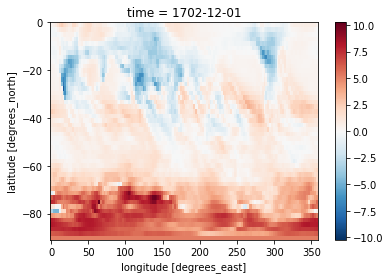

In [20]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
d18O_shem_seas_mean_detrend_ctrl = d18O_shem_tmon_detrend_ctrl[2:(len(d18O_shem_tmon_detrend_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
d18O_shem_seas_mean_detrend_ctrl[3].plot()

<xarray.DataArray (time: 74, lat: 48, lon: 144)>
array([[[ 5.274947,  5.275031, ...,  5.27493 ,  5.27495 ],
        [ 6.325275,  6.269503, ...,  6.183491,  6.267133],
        ...,
        [-0.222683, -0.240195, ...,  0.208246, -0.050296],
        [ 0.261522,  0.387925, ...,  0.648636,  0.387157]],

       [[ 5.717506,  5.717548, ...,  5.717468,  5.717525],
        [ 5.810336,  5.785065, ...,  5.768663,  5.808046],
        ...,
        [-0.380419, -0.573361, ..., -0.155049, -0.327707],
        [ 0.790353,  0.650691, ...,  0.881687,  0.851844]],

       ...,

       [[ 5.984774,  5.984705, ...,  5.984613,  5.984636],
        [ 5.860991,  6.017289, ...,  5.471504,  5.665907],
        ...,
        [ 0.273873,  0.405771, ...,  0.338869,  0.292393],
        [ 0.726061,  0.647151, ...,  0.846438,  0.807386]],

       [[ 6.016973,  6.016924, ...,  6.016872,  6.016874],
        [ 5.346649,  5.366834, ...,  5.218721,  5.297258],
        ...,
        [-0.278466, -0.187133, ...,  0.161263, -0.1168

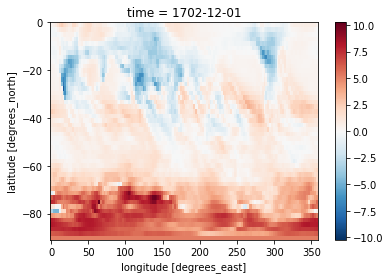

In [21]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_d18O_shem_seas_mean_detrend_ctrl = d18O_shem_seas_mean_detrend_ctrl.sel(time=is_djf(d18O_shem_seas_mean_detrend_ctrl['time.month']))
mam_d18O_shem_seas_mean_detrend_ctrl = d18O_shem_seas_mean_detrend_ctrl.sel(time=is_mam(d18O_shem_seas_mean_detrend_ctrl['time.month']))
jja_d18O_shem_seas_mean_detrend_ctrl = d18O_shem_seas_mean_detrend_ctrl.sel(time=is_jja(d18O_shem_seas_mean_detrend_ctrl['time.month']))
son_d18O_shem_seas_mean_detrend_ctrl = d18O_shem_seas_mean_detrend_ctrl.sel(time=is_son(d18O_shem_seas_mean_detrend_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_d18O_shem_seas_mean_detrend_ctrl[0].plot()
print(djf_d18O_shem_seas_mean_detrend_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

In [22]:
#Field variable with annual mean

d18O_shem_ann_mean_detrend_ctrl = d18O_shem_tmon_detrend_ctrl.resample(time='AS').mean(axis=0)
d18O_shem_ann_mean_detrend_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray (time: 75, lat: 48, lon: 144)>
array([[[-1.207869e+00, -1.207804e+00, ..., -1.207914e+00, -1.207887e+00],
        [-1.022496e+00, -1.055791e+00, ..., -1.001254e+00, -9.955195e-01],
        ...,
        [ 3.520727e-02,  3.425809e-02, ..., -3.537367e-02,  3.617783e-03],
        [-1.091844e-01, -6.236261e-02, ..., -1.062390e-01, -7.097469e-02]],

       [[ 2.039396e+00,  2.039296e+00, ...,  2.039458e+00,  2.039426e+00],
        [ 1.616510e+00,  1.656289e+00, ...,  1.531908e+00,  1.577295e+00],
        ...,
        [ 7.995427e-03,  8.453269e-03, ...,  1.221472e-01,  3.256470e-02],
        [-9.189646e-04, -6.002412e-02, ...,  7.140976e-02,  9.520221e-02]],

       ...,

       [[ 1.909204e+00,  1.909191e+00, ...,  1.909252e+00,  1.909250e+00],
        [ 1.631885e+00,  1.601889e+00, ...,  1.680593e+00,  1.657768e+00],
        ...,
        [-1.405255e-01, -9.000822e-02, ..., -1.953572e-01, -1.757717e-01],
        [-2.683839e-01, -3.352275e-01, ..., -2.684866e-01, -2.773210e-

In [23]:
#Find SAM values for each of the time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_ctrl = pd.DataFrame(data=d)
print(SAM_djf_mean_ctrl)

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_ctrl = pd.DataFrame(data=d)
# SAM_mam_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_ctrl = pd.DataFrame(data=d)
# SAM_jja_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
SAM_son_mean_ctrl = pd.DataFrame(data=d)
# SAM_son_mean_ctrl

d = {'SAM': SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna()),1)}
SAM_ann_mean_ctrl = pd.DataFrame(data=d)
# SAM_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_ctrl
SAM_djf_mean_upper_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_ctrl

SAM_mam_mean_lower_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_ctrl
SAM_mam_mean_upper_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_ctrl

SAM_jja_mean_lower_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_ctrl
SAM_jja_mean_upper_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_ctrl

SAM_son_mean_lower_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_ctrl
SAM_son_mean_upper_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_ctrl

SAM_ann_mean_lower_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_ctrl
SAM_ann_mean_upper_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
SAM_ann_mean_upper_ctrl

                 SAM  indice
time                        
1702-12-01  0.218712       0
1703-12-01 -0.754660       1
1704-12-01 -1.357704       2
1705-12-01  0.107207       3
1706-12-01 -0.077371       4
1707-12-01 -0.917796       5
1708-12-01  0.492444       6
1709-12-01  0.506399       7
1710-12-01  0.709614       8
1711-12-01  1.159070       9
1712-12-01  1.063509      10
1713-12-01  0.384797      11
1714-12-01 -1.327801      12
1715-12-01  0.639639      13
1716-12-01  1.030930      14
1717-12-01 -0.390278      15
1718-12-01  0.471380      16
1719-12-01 -0.090453      17
1720-12-01 -0.000426      18
1721-12-01 -0.052087      19
1722-12-01 -0.454987      20
1723-12-01  0.568290      21
1724-12-01  0.023892      22
1725-12-01 -0.104740      23
1726-12-01  0.202749      24
1727-12-01  0.626337      25
1728-12-01  0.569371      26
1729-12-01 -1.282789      27
1730-12-01  0.501245      28
1731-12-01 -1.230454      29
...              ...     ...
1746-12-01 -1.979640      44
1747-12-01  0.

[15, 53, 29, 25, 23, 72, 11, 4, 63, 64, 8, 48, 70, 21, 50, 10, 14, 62, 9]

In [24]:
djf_d18O_shem_seas_mean_detrend_ctrl

<xarray.DataArray (time: 74, lat: 48, lon: 144)>
array([[[ 5.274947,  5.275031, ...,  5.27493 ,  5.27495 ],
        [ 6.325275,  6.269503, ...,  6.183491,  6.267133],
        ...,
        [-0.222683, -0.240195, ...,  0.208246, -0.050296],
        [ 0.261522,  0.387925, ...,  0.648636,  0.387157]],

       [[ 5.717506,  5.717548, ...,  5.717468,  5.717525],
        [ 5.810336,  5.785065, ...,  5.768663,  5.808046],
        ...,
        [-0.380419, -0.573361, ..., -0.155049, -0.327707],
        [ 0.790353,  0.650691, ...,  0.881687,  0.851844]],

       ...,

       [[ 5.984774,  5.984705, ...,  5.984613,  5.984636],
        [ 5.860991,  6.017289, ...,  5.471504,  5.665907],
        ...,
        [ 0.273873,  0.405771, ...,  0.338869,  0.292393],
        [ 0.726061,  0.647151, ...,  0.846438,  0.807386]],

       [[ 6.016973,  6.016924, ...,  6.016872,  6.016874],
        [ 5.346649,  5.366834, ...,  5.218721,  5.297258],
        ...,
        [-0.278466, -0.187133, ...,  0.161263, -0.1168

In [25]:
SAM_djf_mean_upper_ctrl

[13, 45, 8, 66, 67, 61, 62, 39, 63, 72, 53, 14, 54, 10, 51, 43, 9, 59]

In [26]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_upper_SAM_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_w_lower_SAM_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_d18O_w_upper_SAM_detrend_ctrl
# djf_d18O_w_lower_SAM_detrend_ctrl

#mam
mam_d18O_w_upper_SAM_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_w_lower_SAM_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_d18O_w_upper_SAM_detrend_ctrl
# mam_d18O_w_lower_SAM_detrend_ctrl

#jja
jja_d18O_w_upper_SAM_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_w_lower_SAM_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_d18O_w_upper_SAM_detrend_ctrl
# jja_d18O_w_lower_SAM_detrend_ctrl

#son
son_d18O_w_upper_SAM_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_d18O_w_lower_SAM_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = SAM_son_mean_lower_ctrl)
# son_d18O_w_upper_SAM_detrend_ctrl
# son_d18O_w_lower_SAM_detrend_ctrl

#ann mean
ann_mean_d18O_w_upper_SAM_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_w_lower_SAM_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = SAM_ann_mean_lower_ctrl)
# ann_mean_d18O_w_upper_SAM_detrend_ctrl
ann_mean_d18O_w_lower_SAM_detrend_ctrl


<xarray.DataArray (time: 19, lat: 48, lon: 144)>
array([[[ 0.774452,  0.774475, ...,  0.774654,  0.774669],
        [ 0.970464,  0.935555, ...,  1.010579,  1.003452],
        ...,
        [ 0.644115,  0.711616, ...,  0.43116 ,  0.528868],
        [ 0.418553,  0.494889, ...,  0.274813,  0.33397 ]],

       [[-0.459581, -0.45947 , ..., -0.459318, -0.459281],
        [-0.17403 , -0.157127, ..., -0.249384, -0.207281],
        ...,
        [-0.297907, -0.302702, ..., -0.196752, -0.241738],
        [-0.181582, -0.152308, ..., -0.095226, -0.128168]],

       ...,

       [[-1.207869, -1.207804, ..., -1.207914, -1.207887],
        [-1.022496, -1.055791, ..., -1.001254, -0.995519],
        ...,
        [ 0.035207,  0.034258, ..., -0.035374,  0.003618],
        [-0.109184, -0.062363, ..., -0.106239, -0.070975]],

       [[-0.978084, -0.978161, ..., -0.978247, -0.978224],
        [-0.743384, -0.710341, ..., -0.853102, -0.81044 ],
        ...,
        [ 0.123298,  0.058339, ...,  0.177601,  0.1504

In [27]:
Rel_CP_son_mean_indices_raw_ctrl

,vals,lats,lons,sectormean,indice
time,,,,,
1702-09-01,-5.844826,-72.947368,192.5,986.232521,0
1703-09-01,-6.729784,-71.052632,257.5,989.859422,1
1704-09-01,-8.893621,-72.947368,205.0,982.110113,2
1705-09-01,-9.095358,-74.842105,200.0,982.935141,3
1706-09-01,-7.593004,-71.052632,222.5,980.201891,4
1707-09-01,-9.630977,-72.947368,195.0,988.421992,5
1708-09-01,-6.758978,-71.052632,202.5,983.607122,6
1709-09-01,-7.292528,-74.842105,197.5,984.151110,7
1710-09-01,-9.328909,-71.052632,222.5,979.558829,8


In [28]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl
djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl
mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl
jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_SAM_detrend_ctrl
son_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_lower_ctrl]
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl



,vals,lats,lons,sectormean,indice
time,,,,,
1758-01-01,-5.556601,-71.052632,205.0,987.675314,56
1733-01-01,-5.571533,-69.157895,185.0,991.061340,31
1703-01-01,-5.095673,-71.052632,195.0,989.296173,1
1704-01-01,-4.715917,-71.052632,205.0,989.053075,2
1773-01-01,-6.123341,-72.947368,205.0,988.206654,71
1746-01-01,-5.889760,-71.052632,200.0,988.050100,44
1767-01-01,-6.181909,-71.052632,212.5,987.588647,65
1738-01-01,-4.146518,-71.052632,227.5,987.218112,36
1771-01-01,-4.057822,-69.157895,237.5,985.992393,69


In [29]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_SAM_ttest_stats_ctrl, djf_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_upper_SAM_detrend_ctrl, djf_d18O_w_lower_SAM_detrend_ctrl, axis=0)

mam_d18O_change_due_to_SAM_ttest_stats_ctrl, mam_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_upper_SAM_detrend_ctrl, mam_d18O_w_lower_SAM_detrend_ctrl, axis=0)

jja_d18O_change_due_to_SAM_ttest_stats_ctrl, jja_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_upper_SAM_detrend_ctrl, jja_d18O_w_lower_SAM_detrend_ctrl, axis=0)

son_d18O_change_due_to_SAM_ttest_stats_ctrl, son_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_upper_SAM_detrend_ctrl, son_d18O_w_lower_SAM_detrend_ctrl, axis=0)

ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl, ann_mean_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_upper_SAM_detrend_ctrl, ann_mean_d18O_w_lower_SAM_detrend_ctrl, axis=0)

### Before Plotting, going to calculate the d18O contributions from each Tagged region as well as the total d18O change from pseudoWDC

In [30]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_djf_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_mam_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_jja_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = SAM_son_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = SAM_ann_mean_lower_ctrl)

In [31]:
print('pseudoWDC DJF SAM Upper =',np.round(djf_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF SAM Lower =',np.round(djf_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF SAM Diff =',np.round(djf_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 30to60 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 60to90 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 00to30 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 30to60 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 60to90 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 00to30 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 30to60 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 60to90 DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA land DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA land DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA land DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA ice DJF SAM Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice DJF SAM Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice DJF SAM Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('pseudoWDC MAM SAM Upper =',np.round(mam_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM SAM Lower =',np.round(mam_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM SAM Diff =',np.round(mam_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 30to60 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 60to90 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 00to30 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 30to60 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 60to90 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 00to30 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 30to60 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 60to90 MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA land MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA land MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA land MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA ice MAM SAM Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice MAM SAM Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice MAM SAM Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('pseudoWDC JJA SAM Upper =',np.round(jja_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA SAM Lower =',np.round(jja_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA SAM Diff =',np.round(jja_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 30to60 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 60to90 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 00to30 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 30to60 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 60to90 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 00to30 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 30to60 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 60to90 JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA land JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA land JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA land JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA ice JJA SAM Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice JJA SAM Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice JJA SAM Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('pseudoWDC SON SAM Upper =',np.round(son_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON SAM Lower =',np.round(son_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON SAM Diff =',np.round(son_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 30to60 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 60to90 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 00to30 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 30to60 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 60to90 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 00to30 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 30to60 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 60to90 SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA land SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA land SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA land SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA ice SON SAM Upper =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice SON SAM Lower =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice SON SAM Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('pseudoWDC Ann Mean SAM Upper =',np.round(ann_mean_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean SAM Lower =',np.round(ann_mean_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean SAM Diff =',np.round(ann_mean_d18O_w_upper_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_lower_SAM_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 30to60 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Atl 60to90 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 00to30 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 30to60 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Pac 60to90 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 00to30 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 30to60 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('Ind 60to90 Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_SAM_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean SAM Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean SAM Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean SAM Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_SAM_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_SAM_ctrl.mean(axis=0).values,2))

pseudoWDC DJF SAM Upper = 3.54 , pseudoWDC DJF SAM Lower = 4.21 , pseudoWDC DJF SAM Diff = -0.67
Atl 00to30 DJF SAM Upper = 0.03 , Atl 00to30 DJF SAM Lower = 0.03 , Atl 00to30 DJF SAM Diff = -0.0
Atl 30to60 DJF SAM Upper = -0.05 , Atl 30to60 DJF SAM Lower = 0.07 , Atl 30to60 DJF SAM Diff = -0.12
Atl 60to90 DJF SAM Upper = -0.05 , Atl 60to90 DJF SAM Lower = 0.0 , Atl 60to90 DJF SAM Diff = -0.05
Pac 00to30 DJF SAM Upper = 0.17 , Pac 00to30 DJF SAM Lower = -0.16 , Pac 00to30 DJF SAM Diff = 0.33
Pac 30to60 DJF SAM Upper = 0.07 , Pac 30to60 DJF SAM Lower = -0.11 , Pac 30to60 DJF SAM Diff = 0.18
Pac 60to90 DJF SAM Upper = -0.1 , Pac 60to90 DJF SAM Lower = 0.07 , Pac 60to90 DJF SAM Diff = -0.18
Ind 00to30 DJF SAM Upper = 0.05 , Ind 00to30 DJF SAM Lower = -0.04 , Ind 00to30 DJF SAM Diff = 0.09
Ind 30to60 DJF SAM Upper = -0.23 , Ind 30to60 DJF SAM Lower = 0.38 , Ind 30to60 DJF SAM Diff = -0.61
Ind 60to90 DJF SAM Upper = -0.04 , Ind 60to90 DJF SAM Lower = 0.04 , Ind 60to90 DJF SAM Diff = -0.08
A

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-4.9006856442428495 -4.334664159718601


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.9532959019987315 -6.00313496077386


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.416681147344788 -8.54199293308687


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-8.127777513028976 -7.011836237000317


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.386607262488048 -5.541187217482436


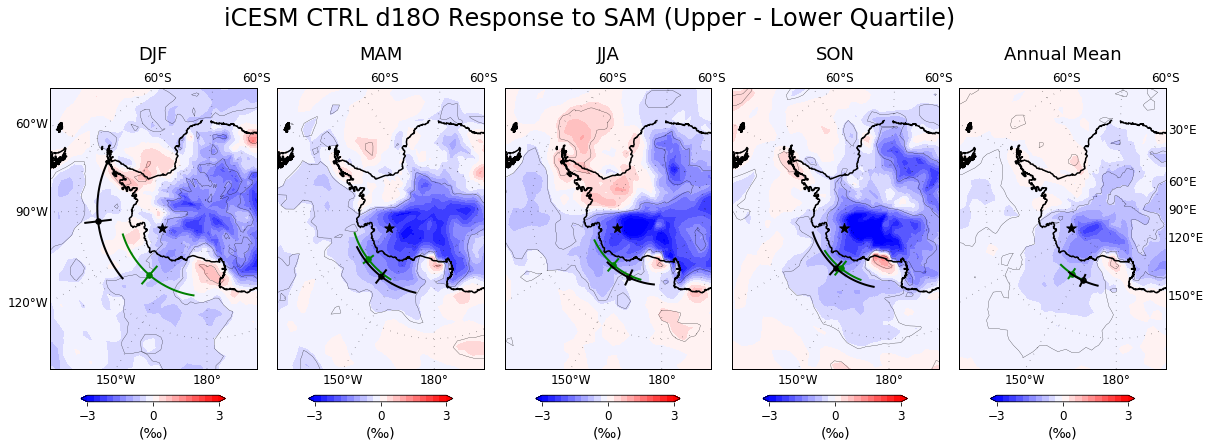

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Response to SAM (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_mam = mam_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_jja = jja_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_son = son_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = addcyclic(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_sh, lons = addcyclic(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_sh, lons = addcyclic(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_sh, lons = addcyclic(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_sh, lons = addcyclic(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_djf_con, lons = addcyclic(djf_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_con, lons = addcyclic(mam_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_con, lons = addcyclic(jja_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_con, lons = addcyclic(son_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_con, lons = addcyclic(ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-3,3.3,.3)
levels_contour = [-2.028,2.028] #good for seasons, and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((djf_d18O_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (djf_d18O_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((mam_d18O_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (mam_d18O_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((jja_d18O_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (jja_d18O_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((son_d18O_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (son_d18O_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_d18O_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Field_vs_SAM_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [33]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA1_djf_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA1_mam_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA1_jja_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_ctrl = pd.DataFrame(data=d)
# PSA1_son_mean_ctrl

d = {'PSA1': SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna()),1)}
PSA1_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA1_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_ctrl
PSA1_djf_mean_upper_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_ctrl

PSA1_mam_mean_lower_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_ctrl
PSA1_mam_mean_upper_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_ctrl

PSA1_jja_mean_lower_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_ctrl
PSA1_jja_mean_upper_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_ctrl

PSA1_son_mean_lower_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_ctrl
PSA1_son_mean_upper_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_ctrl

PSA1_ann_mean_lower_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_ctrl
PSA1_ann_mean_upper_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_ctrl

In [34]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_upper_PSA1_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_w_lower_PSA1_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
print(djf_d18O_w_upper_PSA1_detrend_ctrl)
# djf_d18O_w_lower_PSA1_detrend_ctrl

#mam
mam_d18O_w_upper_PSA1_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_w_lower_PSA1_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_d18O_w_upper_PSA1_detrend_ctrl
# mam_d18O_w_lower_PSA1_detrend_ctrl

#jja
jja_d18O_w_upper_PSA1_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_w_lower_PSA1_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_d18O_w_upper_PSA1_detrend_ctrl
# jja_d18O_w_lower_PSA1_detrend_ctrl

#son
son_d18O_w_upper_PSA1_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_w_lower_PSA1_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
print(son_d18O_w_upper_PSA1_detrend_ctrl)
# son_d18O_w_lower_PSA1_detrend_ctrl

#ann mean
ann_mean_d18O_w_upper_PSA1_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_w_lower_PSA1_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_d18O_w_upper_PSA1_detrend_ctrl
# ann_mean_d18O_w_lower_PSA1_detrend_ctrl


<xarray.DataArray (time: 18, lat: 48, lon: 144)>
array([[[ 5.837807,  5.837814, ...,  5.837766,  5.837762],
        [ 6.023913,  6.039291, ...,  6.015705,  6.057247],
        ...,
        [-0.098215, -0.10509 , ...,  0.041498, -0.083653],
        [ 0.909224,  1.049143, ...,  0.834176,  0.854388]],

       [[ 5.878723,  5.878677, ...,  5.87861 ,  5.87862 ],
        [ 4.615407,  4.787318, ...,  4.411405,  4.46764 ],
        ...,
        [-0.060983, -0.106127, ...,  0.230406,  0.123175],
        [ 0.90339 ,  0.823103, ...,  0.949088,  0.925717]],

       ...,

       [[ 5.274947,  5.275031, ...,  5.27493 ,  5.27495 ],
        [ 6.325275,  6.269503, ...,  6.183491,  6.267133],
        ...,
        [-0.222683, -0.240195, ...,  0.208246, -0.050296],
        [ 0.261522,  0.387925, ...,  0.648636,  0.387157]],

       [[ 6.541865,  6.542131, ...,  6.542741,  6.542764],
        [ 7.428312,  7.350592, ...,  7.342313,  7.413374],
        ...,
        [-1.085153, -1.271017, ..., -0.604652, -0.8844

In [35]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl



In [36]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_PSA1_ttest_stats_ctrl, djf_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_upper_PSA1_detrend_ctrl, djf_d18O_w_lower_PSA1_detrend_ctrl, axis=0)

mam_d18O_change_due_to_PSA1_ttest_stats_ctrl, mam_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_upper_PSA1_detrend_ctrl, mam_d18O_w_lower_PSA1_detrend_ctrl, axis=0)

jja_d18O_change_due_to_PSA1_ttest_stats_ctrl, jja_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_upper_PSA1_detrend_ctrl, jja_d18O_w_lower_PSA1_detrend_ctrl, axis=0)

son_d18O_change_due_to_PSA1_ttest_stats_ctrl, son_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_upper_PSA1_detrend_ctrl, son_d18O_w_lower_PSA1_detrend_ctrl, axis=0)

ann_mean_d18O_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_d18O_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_upper_PSA1_detrend_ctrl, ann_mean_d18O_w_lower_PSA1_detrend_ctrl, axis=0)

### Before Plotting, going to calculate the d18O contributions from each Tagged region as well as the total d18O change from pseudoWDC

In [37]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_djf_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_mam_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_jja_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA1_son_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA1_ann_mean_lower_ctrl)

In [38]:
print('pseudoWDC DJF PSA1 Upper =',np.round(djf_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA1 Lower =',np.round(djf_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA1 Diff =',np.round(djf_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 30to60 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 60to90 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 00to30 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 30to60 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 60to90 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 00to30 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 30to60 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 60to90 DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice DJF PSA1 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA1 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA1 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('pseudoWDC MAM PSA1 Upper =',np.round(mam_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA1 Lower =',np.round(mam_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA1 Diff =',np.round(mam_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 30to60 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 60to90 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 00to30 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 30to60 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 60to90 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 00to30 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 30to60 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 60to90 MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice MAM PSA1 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA1 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA1 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('pseudoWDC JJA PSA1 Upper =',np.round(jja_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA1 Lower =',np.round(jja_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA1 Diff =',np.round(jja_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 30to60 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 60to90 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 00to30 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 30to60 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 60to90 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 00to30 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 30to60 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 60to90 JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice JJA PSA1 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA1 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA1 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('pseudoWDC SON PSA1 Upper =',np.round(son_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA1 Lower =',np.round(son_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA1 Diff =',np.round(son_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 30to60 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 60to90 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 00to30 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 30to60 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 60to90 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 00to30 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 30to60 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 60to90 SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice SON PSA1 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA1 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA1 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('pseudoWDC Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_w_upper_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_lower_PSA1_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 30to60 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Atl 60to90 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 00to30 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 30to60 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Pac 60to90 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 00to30 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 30to60 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('Ind 60to90 Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA1_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean PSA1 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA1 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA1 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA1_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA1_ctrl.mean(axis=0).values,2))

pseudoWDC DJF PSA1 Upper = 3.88 , pseudoWDC DJF PSA1 Lower = 4.18 , pseudoWDC DJF PSA1 Diff = -0.3
Atl 00to30 DJF PSA1 Upper = -0.01 , Atl 00to30 DJF PSA1 Lower = 0.04 , Atl 00to30 DJF PSA1 Diff = -0.05
Atl 30to60 DJF PSA1 Upper = 0.01 , Atl 30to60 DJF PSA1 Lower = 0.09 , Atl 30to60 DJF PSA1 Diff = -0.08
Atl 60to90 DJF PSA1 Upper = 0.07 , Atl 60to90 DJF PSA1 Lower = 0.01 , Atl 60to90 DJF PSA1 Diff = 0.06
Pac 00to30 DJF PSA1 Upper = 0.01 , Pac 00to30 DJF PSA1 Lower = -0.07 , Pac 00to30 DJF PSA1 Diff = 0.09
Pac 30to60 DJF PSA1 Upper = 0.25 , Pac 30to60 DJF PSA1 Lower = -0.39 , Pac 30to60 DJF PSA1 Diff = 0.63
Pac 60to90 DJF PSA1 Upper = 0.11 , Pac 60to90 DJF PSA1 Lower = -0.02 , Pac 60to90 DJF PSA1 Diff = 0.13
Ind 00to30 DJF PSA1 Upper = -0.09 , Ind 00to30 DJF PSA1 Lower = 0.07 , Ind 00to30 DJF PSA1 Diff = -0.16
Ind 30to60 DJF PSA1 Upper = -0.24 , Ind 30to60 DJF PSA1 Lower = 0.42 , Ind 30to60 DJF PSA1 Diff = -0.66
Ind 60to90 DJF PSA1 Upper = -0.02 , Ind 60to90 DJF PSA1 Lower = 0.02 , Ind 

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.106986103323708 -4.515817744437799


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.229096456814222 -7.534570793525045


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.024108736384415 -8.221795111436869


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-8.02506695740981 -7.543635169409012


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.138386531665141 -5.635352124021916


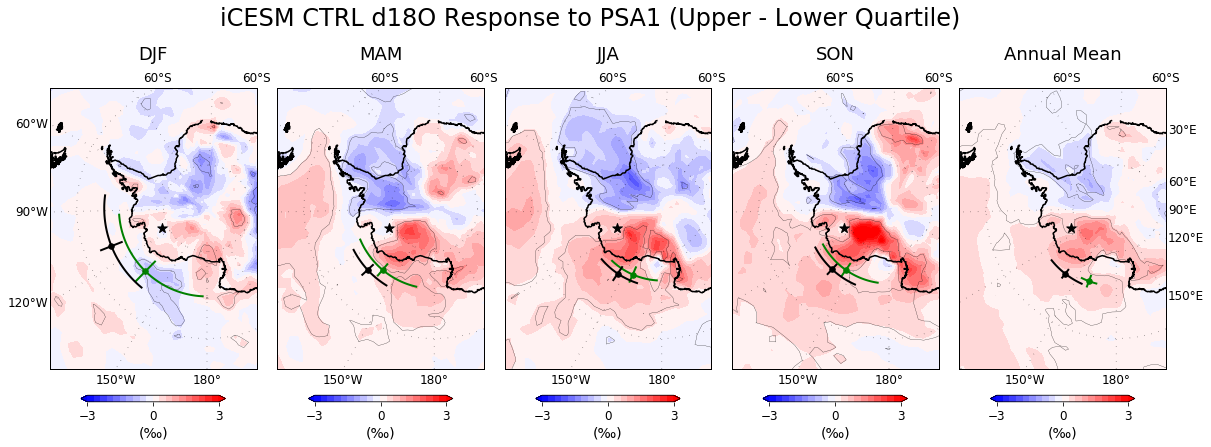

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Response to PSA1 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_mam = mam_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_jja = jja_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_son = son_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = addcyclic(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_sh, lons = addcyclic(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_sh, lons = addcyclic(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_sh, lons = addcyclic(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_sh, lons = addcyclic(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_djf_con, lons = addcyclic(djf_d18O_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_con, lons = addcyclic(mam_d18O_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_con, lons = addcyclic(jja_d18O_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_con, lons = addcyclic(son_d18O_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_con, lons = addcyclic(ann_mean_d18O_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-3,3.3,.3)
levels_contour = [-2.028,2.028] #good for seasons, 12roll, and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((djf_d18O_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (djf_d18O_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((mam_d18O_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (mam_d18O_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((jja_d18O_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (jja_d18O_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((son_d18O_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (son_d18O_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_d18O_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((ann_mean_d18O_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_d18O_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Field_vs_PSA1_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [40]:
#Find PSA2 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA2_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA2_djf_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA2_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA2_mam_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA2_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA2_jja_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA2_son_mean_ctrl = pd.DataFrame(data=d)
# PSA2_son_mean_ctrl

d = {'PSA2': SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna()),1)}
PSA2_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA2_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA2'
#Note, head is lower (sorted from low to high)
PSA2_djf_mean_lower_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_djf_mean_lower_ctrl
PSA2_djf_mean_upper_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_djf_mean_upper_ctrl

PSA2_mam_mean_lower_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_mam_mean_lower_ctrl
PSA2_mam_mean_upper_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_mam_mean_upper_ctrl

PSA2_jja_mean_lower_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_jja_mean_lower_ctrl
PSA2_jja_mean_upper_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_jja_mean_upper_ctrl

PSA2_son_mean_lower_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_son_mean_lower_ctrl
PSA2_son_mean_upper_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_son_mean_upper_ctrl

PSA2_ann_mean_lower_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_ann_mean_lower_ctrl
PSA2_ann_mean_upper_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_ann_mean_upper_ctrl

In [41]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_upper_PSA2_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_w_lower_PSA2_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_djf_mean_lower_ctrl)
# djf_d18O_w_upper_PSA2_detrend_ctrl
# djf_d18O_w_lower_PSA2_detrend_ctrl

#mam
mam_d18O_w_upper_PSA2_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_w_lower_PSA2_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_mam_mean_lower_ctrl)
# mam_d18O_w_upper_PSA2_detrend_ctrl
# mam_d18O_w_lower_PSA2_detrend_ctrl

#jja
jja_d18O_w_upper_PSA2_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_w_lower_PSA2_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_jja_mean_lower_ctrl)
# jja_d18O_w_upper_PSA2_detrend_ctrl
# jja_d18O_w_lower_PSA2_detrend_ctrl

#son
son_d18O_w_upper_PSA2_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_w_lower_PSA2_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_w_upper_PSA2_detrend_ctrl
# son_d18O_w_lower_PSA2_detrend_ctrl

#ann mean
ann_mean_d18O_w_upper_PSA2_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_w_lower_PSA2_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = PSA2_ann_mean_lower_ctrl)
# ann_mean_d18O_w_upper_PSA2_detrend_ctrl
# ann_mean_d18O_w_lower_PSA2_detrend_ctrl


In [42]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA2_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA2_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA2_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA2_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA2_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA2_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA2_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA2_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA2_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA2_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl



In [43]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_PSA2_ttest_stats_ctrl, djf_d18O_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_upper_PSA2_detrend_ctrl, djf_d18O_w_lower_PSA2_detrend_ctrl, axis=0)

mam_d18O_change_due_to_PSA2_ttest_stats_ctrl, mam_d18O_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_upper_PSA2_detrend_ctrl, mam_d18O_w_lower_PSA2_detrend_ctrl, axis=0)

jja_d18O_change_due_to_PSA2_ttest_stats_ctrl, jja_d18O_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_upper_PSA2_detrend_ctrl, jja_d18O_w_lower_PSA2_detrend_ctrl, axis=0)

son_d18O_change_due_to_PSA2_ttest_stats_ctrl, son_d18O_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_upper_PSA2_detrend_ctrl, son_d18O_w_lower_PSA2_detrend_ctrl, axis=0)

ann_mean_d18O_change_due_to_PSA2_ttest_stats_ctrl, ann_mean_d18O_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_upper_PSA2_detrend_ctrl, ann_mean_d18O_w_lower_PSA2_detrend_ctrl, axis=0)

### Before Plotting, going to calculate the d18O contributions from each Tagged region as well as the total d18O change from pseudoWDC

In [44]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_upper_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_djf_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_upper_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_mam_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_upper_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_jja_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_upper_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = PSA2_son_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_upper_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = PSA2_ann_mean_lower_ctrl)

In [45]:
print('pseudoWDC DJF PSA2 Upper =',np.round(djf_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA2 Lower =',np.round(djf_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF PSA2 Diff =',np.round(djf_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 30to60 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 60to90 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 00to30 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 30to60 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 60to90 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 00to30 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 30to60 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 60to90 DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA land DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA ice DJF PSA2 Upper =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA2 Lower =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice DJF PSA2 Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('pseudoWDC MAM PSA2 Upper =',np.round(mam_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA2 Lower =',np.round(mam_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM PSA2 Diff =',np.round(mam_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 30to60 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 60to90 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 00to30 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 30to60 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 60to90 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 00to30 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 30to60 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 60to90 MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA land MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA ice MAM PSA2 Upper =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA2 Lower =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice MAM PSA2 Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('pseudoWDC JJA PSA2 Upper =',np.round(jja_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA2 Lower =',np.round(jja_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA PSA2 Diff =',np.round(jja_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 30to60 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 60to90 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 00to30 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 30to60 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 60to90 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 00to30 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 30to60 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 60to90 JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA land JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA ice JJA PSA2 Upper =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA2 Lower =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice JJA PSA2 Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('pseudoWDC SON PSA2 Upper =',np.round(son_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA2 Lower =',np.round(son_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON PSA2 Diff =',np.round(son_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 30to60 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 60to90 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 00to30 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 30to60 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 60to90 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 00to30 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 30to60 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 60to90 SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA land SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA ice SON PSA2 Upper =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA2 Lower =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice SON PSA2 Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('pseudoWDC Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_w_upper_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_lower_PSA2_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 30to60 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Atl 60to90 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 00to30 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 30to60 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Pac 60to90 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 00to30 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 30to60 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('Ind 60to90 Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_lower_PSA2_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean PSA2 Upper =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA2 Lower =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean PSA2 Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_upper_PSA2_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_lower_PSA2_ctrl.mean(axis=0).values,2))

pseudoWDC DJF PSA2 Upper = 3.92 , pseudoWDC DJF PSA2 Lower = 4.34 , pseudoWDC DJF PSA2 Diff = -0.43
Atl 00to30 DJF PSA2 Upper = 0.0 , Atl 00to30 DJF PSA2 Lower = -0.01 , Atl 00to30 DJF PSA2 Diff = 0.02
Atl 30to60 DJF PSA2 Upper = 0.01 , Atl 30to60 DJF PSA2 Lower = 0.15 , Atl 30to60 DJF PSA2 Diff = -0.14
Atl 60to90 DJF PSA2 Upper = -0.04 , Atl 60to90 DJF PSA2 Lower = 0.07 , Atl 60to90 DJF PSA2 Diff = -0.11
Pac 00to30 DJF PSA2 Upper = 0.03 , Pac 00to30 DJF PSA2 Lower = -0.09 , Pac 00to30 DJF PSA2 Diff = 0.13
Pac 30to60 DJF PSA2 Upper = -0.15 , Pac 30to60 DJF PSA2 Lower = -0.02 , Pac 30to60 DJF PSA2 Diff = -0.13
Pac 60to90 DJF PSA2 Upper = 0.08 , Pac 60to90 DJF PSA2 Lower = 0.04 , Pac 60to90 DJF PSA2 Diff = 0.03
Ind 00to30 DJF PSA2 Upper = -0.05 , Ind 00to30 DJF PSA2 Lower = -0.01 , Ind 00to30 DJF PSA2 Diff = -0.05
Ind 30to60 DJF PSA2 Upper = 0.01 , Ind 30to60 DJF PSA2 Lower = 0.34 , Ind 30to60 DJF PSA2 Diff = -0.33
Ind 60to90 DJF PSA2 Upper = 0.01 , Ind 60to90 DJF PSA2 Lower = 0.02 , Ind

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.374876643481325 -4.486435325784612


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.908089215714785 -8.050070780168431


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.786907935729884 -10.248190862856978


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.157968732370154 -8.815137848276686


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.365339134086364 -6.6296034630651155


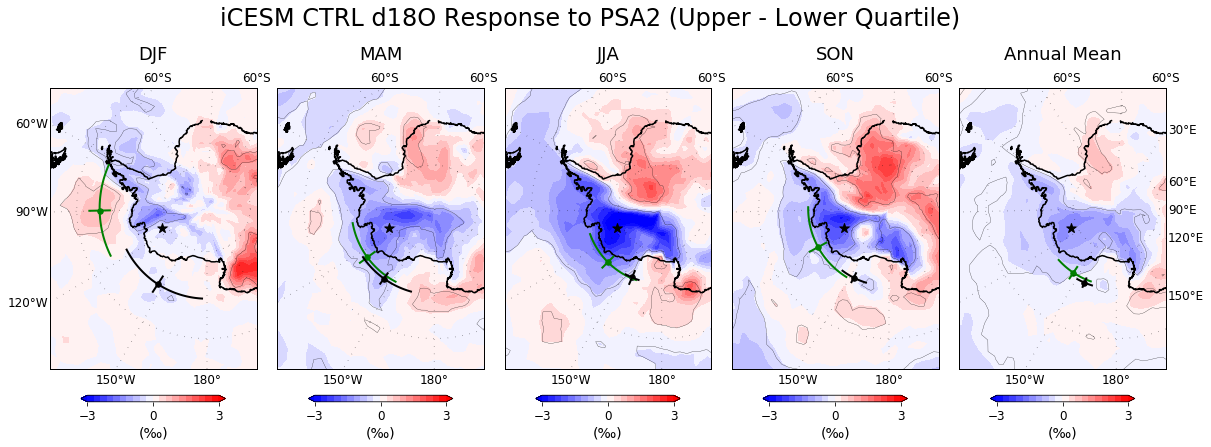

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Response to PSA2 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_mam = mam_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_jja = jja_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_son = son_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = addcyclic(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_sh, lons = addcyclic(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_sh, lons = addcyclic(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_sh, lons = addcyclic(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_sh, lons = addcyclic(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_djf_con, lons = addcyclic(djf_d18O_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_con, lons = addcyclic(mam_d18O_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_con, lons = addcyclic(jja_d18O_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_con, lons = addcyclic(son_d18O_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_con, lons = addcyclic(ann_mean_d18O_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-3,3.3,.3)
levels_contour = [-2.028,2.028] #good for seasons, 12roll, and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((djf_d18O_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (djf_d18O_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((mam_d18O_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (mam_d18O_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((jja_d18O_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (jja_d18O_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((son_d18O_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (son_d18O_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_d18O_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((ann_mean_d18O_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_d18O_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Field_vs_PSA2_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [47]:
#It would be good to use Long Upper Quart vs Lower Quart and Rel CP Upper Quart vs Lower Quart; this would 
#allow a tie to Hoskings et al and confirm my previous work

#West most is the lower quartile (west has lower long values which range from 0 to 360)
#East most is the upper quartile (east has higher long values which range from 0 to 360)

In [48]:
#create list of indices representing the eastmost/westmost quartiles of 'lons'
#Note, head is westmost (sorted from low to high)
lons_djf_mean_westmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_djf_mean_westmost_ctrl)
lons_djf_mean_eastmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_djf_mean_eastmost_ctrl)

lons_mam_mean_westmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_mam_mean_westmost_ctrl)
lons_mam_mean_eastmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_mam_mean_eastmost_ctrl)

lons_jja_mean_westmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_jja_mean_westmost_ctrl)
lons_jja_mean_eastmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_jja_mean_eastmost_ctrl)

lons_son_mean_westmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_son_mean_westmost_ctrl)
lons_son_mean_eastmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_son_mean_eastmost_ctrl)

lons_ann_mean_westmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_ann_mean_westmost_ctrl)
lons_ann_mean_eastmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_ann_mean_eastmost_ctrl)

[31, 59, 40, 48, 53, 52, 33, 51, 45, 67, 16, 12, 26, 43, 28, 65, 17, 63]
[11, 19, 60, 68, 2, 1, 70, 3, 32, 69, 5, 38, 58, 0, 56, 30, 18, 41]
[63, 35, 20, 44, 61, 40, 30, 52, 62, 16, 37, 5, 1, 18, 19, 21, 60, 64, 4]
[33, 15, 28, 47, 25, 32, 41, 39, 46, 9, 8, 55, 11, 50, 26, 69, 59, 42, 31]
[1, 0, 23, 27, 19, 16, 48, 31, 20, 6, 49, 47, 43, 40, 34, 32, 55, 58, 60]
[12, 63, 21, 29, 38, 9, 51, 36, 25, 14, 7, 26, 39, 28, 61, 5, 62, 41, 66]
[60, 0, 30, 68, 5, 67, 49, 70, 40, 7, 52, 26, 44, 13, 10, 3, 71, 63, 45]
[9, 28, 53, 14, 66, 59, 69, 57, 74, 62, 11, 17, 1, 55, 54, 36, 73, 31, 61]
[31, 1, 30, 20, 0, 67, 60, 52, 49, 40, 32, 27, 44, 6, 61, 22, 19, 37, 16]
[65, 73, 50, 24, 51, 43, 38, 21, 11, 9, 36, 62, 59, 14, 74, 25, 69, 47, 28]


In [49]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_eastmost_lons_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_w_westmost_lons_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
# djf_d18O_w_eastmost_lons_detrend_ctrl
# djf_d18O_w_westmost_lons_detrend_ctrl

#mam
mam_d18O_w_eastmost_lons_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_w_westmost_lons_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
# mam_d18O_w_eastmost_lons_detrend_ctrl
# mam_d18O_w_westmost_lons_detrend_ctrl

#jja
jja_d18O_w_eastmost_lons_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_w_westmost_lons_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
# jja_d18O_w_eastmost_lons_detrend_ctrl
# jja_d18O_w_westmost_lons_detrend_ctrl

#son
son_d18O_w_eastmost_lons_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_w_westmost_lons_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_w_eastmost_lons_detrend_ctrl
# son_d18O_w_westmost_lons_detrend_ctrl

#ann mean
ann_mean_d18O_w_eastmost_lons_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_w_westmost_lons_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = lons_ann_mean_westmost_ctrl)
# ann_mean_d18O_w_eastmost_lons_detrend_ctrl
# ann_mean_d18O_w_westmost_lons_detrend_ctrl


In [50]:
#Select ASL Rel CP value, long, and lat while ASL Lons is in upper (eastmost) or lower (westmost) quartile
#Using new ASL info from 19Nov2018

#djf
djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[lons_djf_mean_eastmost_ctrl]
# djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[lons_djf_mean_westmost_ctrl]
# djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#mam
mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[lons_mam_mean_eastmost_ctrl]
# mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[lons_mam_mean_westmost_ctrl]
# mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#jja
jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[lons_jja_mean_eastmost_ctrl]
# jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[lons_jja_mean_westmost_ctrl]
# jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#son
son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[lons_son_mean_eastmost_ctrl]
# son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[lons_son_mean_westmost_ctrl]
# son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[lons_ann_mean_eastmost_ctrl]
# ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[lons_ann_mean_westmost_ctrl]
# ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl

In [51]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_lons_ttest_stats_ctrl, djf_d18O_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_eastmost_lons_detrend_ctrl, djf_d18O_w_westmost_lons_detrend_ctrl, axis=0)

mam_d18O_change_due_to_lons_ttest_stats_ctrl, mam_d18O_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_eastmost_lons_detrend_ctrl, mam_d18O_w_westmost_lons_detrend_ctrl, axis=0)

jja_d18O_change_due_to_lons_ttest_stats_ctrl, jja_d18O_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_eastmost_lons_detrend_ctrl, jja_d18O_w_westmost_lons_detrend_ctrl, axis=0)

son_d18O_change_due_to_lons_ttest_stats_ctrl, son_d18O_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_eastmost_lons_detrend_ctrl, son_d18O_w_westmost_lons_detrend_ctrl, axis=0)

ann_mean_d18O_change_due_to_lons_ttest_stats_ctrl, ann_mean_d18O_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_eastmost_lons_detrend_ctrl, ann_mean_d18O_w_westmost_lons_detrend_ctrl, axis=0)

In [52]:
djf_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-djf_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)
lons_djf_mean_eastmost_ctrl

[11, 19, 60, 68, 2, 1, 70, 3, 32, 69, 5, 38, 58, 0, 56, 30, 18, 41]

### Before Plotting, going to calculate the d18O contributions from each Tagged region as well as the total d18O change from pseudoWDC

In [53]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in eastmost or westmost quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_djf_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_mam_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_jja_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = lons_son_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = lons_ann_mean_westmost_ctrl)

In [54]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in eastmost or westmost quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_Atl_00to30_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Atl_00to30_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Atl_60to90_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Atl_60to90_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Pac_00to30_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Pac_00to30_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Pac_30to60_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Pac_30to60_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Ind_00to30_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Ind_00to30_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_Ind_60to90_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_Ind_60to90_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_AA_land_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_AA_land_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
djf_d18O_weighted_anoms_AA_ice_w_eastmost_lons_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_d18O_weighted_anoms_AA_ice_w_westmost_lons_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Atl_00to30_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Atl_00to30_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Atl_60to90_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Atl_60to90_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Pac_00to30_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Pac_00to30_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Pac_30to60_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Pac_30to60_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Ind_00to30_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Ind_00to30_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_Ind_60to90_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_Ind_60to90_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_AA_land_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_AA_land_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
mam_d18O_weighted_anoms_AA_ice_w_eastmost_lons_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_d18O_weighted_anoms_AA_ice_w_westmost_lons_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Atl_00to30_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Atl_00to30_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Atl_60to90_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Atl_60to90_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Pac_00to30_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Pac_00to30_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Pac_30to60_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Pac_30to60_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Ind_00to30_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Ind_00to30_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_Ind_60to90_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_Ind_60to90_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_AA_land_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_AA_land_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
jja_d18O_weighted_anoms_AA_ice_w_eastmost_lons_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_d18O_weighted_anoms_AA_ice_w_westmost_lons_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
son_d18O_weighted_anoms_Atl_00to30_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Atl_00to30_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Atl_60to90_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Atl_60to90_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Pac_00to30_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Pac_00to30_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Pac_30to60_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Pac_30to60_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Ind_00to30_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Ind_00to30_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_Ind_60to90_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_Ind_60to90_w_westmost_lons_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_AA_land_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_AA_land_w_westmost_lons_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_d18O_weighted_anoms_AA_ice_w_eastmost_lons_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_d18O_weighted_anoms_AA_ice_w_westmost_lons_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Atl_00to30_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Atl_00to30_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Atl_60to90_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Atl_60to90_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Pac_00to30_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Pac_00to30_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Pac_30to60_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Pac_30to60_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Ind_00to30_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Ind_00to30_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_Ind_60to90_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_Ind_60to90_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_AA_land_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_AA_land_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)
ann_mean_d18O_weighted_anoms_AA_ice_w_eastmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(year = lons_ann_mean_eastmost_ctrl)
ann_mean_d18O_weighted_anoms_AA_ice_w_westmost_lons_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.isel(year = lons_ann_mean_westmost_ctrl)

In [55]:
print('pseudoWDC DJF lons Westmost =',np.round(djf_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF lons Eastmost =',np.round(djf_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF lons Diff =',np.round(djf_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 30to60 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 60to90 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 00to30 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 30to60 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 60to90 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 00to30 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 30to60 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 60to90 DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA land DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA ice DJF lons Westmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice DJF lons Eastmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice DJF lons Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('pseudoWDC MAM lons Westmost =',np.round(mam_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM lons Eastmost =',np.round(mam_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM lons Diff =',np.round(mam_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 30to60 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 60to90 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 00to30 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 30to60 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 60to90 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 00to30 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 30to60 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 60to90 MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA land MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA ice MAM lons Westmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice MAM lons Eastmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice MAM lons Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('pseudoWDC JJA lons Westmost =',np.round(jja_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA lons Eastmost =',np.round(jja_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA lons Diff =',np.round(jja_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 30to60 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 60to90 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 00to30 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 30to60 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 60to90 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 00to30 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 30to60 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 60to90 JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA land JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA ice JJA lons Westmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice JJA lons Eastmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice JJA lons Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('pseudoWDC SON lons Westmost =',np.round(son_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON lons Eastmost =',np.round(son_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON lons Diff =',np.round(son_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 30to60 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 60to90 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 00to30 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 30to60 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 60to90 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 00to30 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 30to60 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 60to90 SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA land SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA ice SON lons Westmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice SON lons Eastmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice SON lons Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('pseudoWDC Ann Mean lons Westmost =',np.round(ann_mean_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean lons Eastmost =',np.round(ann_mean_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean lons Diff =',np.round(ann_mean_d18O_w_westmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_eastmost_lons_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 30to60 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Atl 60to90 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 00to30 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 30to60 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Pac 60to90 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 00to30 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 30to60 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('Ind 60to90 Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_eastmost_lons_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean lons Westmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean lons Eastmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean lons Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_westmost_lons_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_eastmost_lons_ctrl.mean(axis=0).values,2))

pseudoWDC DJF lons Westmost = 3.96 , pseudoWDC DJF lons Eastmost = 3.8 , pseudoWDC DJF lons Diff = 0.17
Atl 00to30 DJF lons Westmost = -0.06 , Atl 00to30 DJF lons Eastmost = -0.0 , Atl 00to30 DJF lons Diff = -0.05
Atl 30to60 DJF lons Westmost = 0.02 , Atl 30to60 DJF lons Eastmost = -0.04 , Atl 30to60 DJF lons Diff = 0.07
Atl 60to90 DJF lons Westmost = 0.12 , Atl 60to90 DJF lons Eastmost = -0.08 , Atl 60to90 DJF lons Diff = 0.2
Pac 00to30 DJF lons Westmost = -0.08 , Pac 00to30 DJF lons Eastmost = 0.05 , Pac 00to30 DJF lons Diff = -0.13
Pac 30to60 DJF lons Westmost = 0.17 , Pac 30to60 DJF lons Eastmost = 0.03 , Pac 30to60 DJF lons Diff = 0.14
Pac 60to90 DJF lons Westmost = 0.11 , Pac 60to90 DJF lons Eastmost = 0.04 , Pac 60to90 DJF lons Diff = 0.07
Ind 00to30 DJF lons Westmost = -0.09 , Ind 00to30 DJF lons Eastmost = -0.04 , Ind 00to30 DJF lons Diff = -0.05
Ind 30to60 DJF lons Westmost = -0.16 , Ind 30to60 DJF lons Eastmost = 0.0 , Ind 30to60 DJF lons Diff = -0.16
Ind 60to90 DJF lons Wes

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-4.772162710615987 -4.831128659289687


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.108318679583135 -6.977721635589833


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.525364717002127 -7.6254337031809465


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-8.073466136203042 -7.260749648332469


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.095707729977005 -5.724653633427136


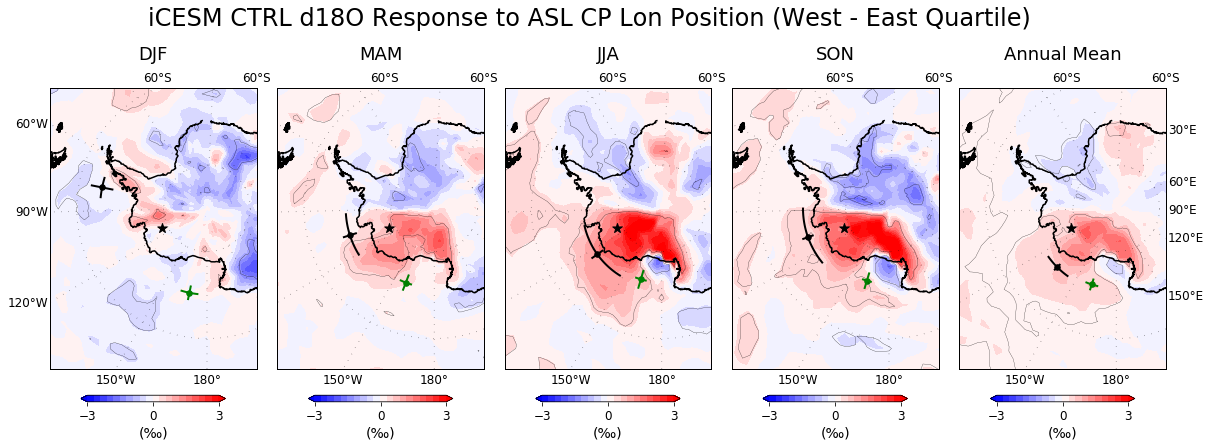

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Response to ASL CP Lon Position (West - East Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-djf_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_mam = mam_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-mam_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_jja = jja_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-jja_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_son = son_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-son_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = addcyclic(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_sh, lons = addcyclic(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_sh, lons = addcyclic(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_sh, lons = addcyclic(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_sh, lons = addcyclic(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_djf_con, lons = addcyclic(djf_d18O_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_con, lons = addcyclic(mam_d18O_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_con, lons = addcyclic(jja_d18O_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_con, lons = addcyclic(son_d18O_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_con, lons = addcyclic(ann_mean_d18O_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-3,3.3,.3)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-djf_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((djf_d18O_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (djf_d18O_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-mam_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((mam_d18O_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (mam_d18O_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-jja_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((jja_d18O_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (jja_d18O_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-son_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((son_d18O_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (son_d18O_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_d18O_w_westmost_lons_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((ann_mean_d18O_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_d18O_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Field_vs_ASL_CP_Lon_Position_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/wor

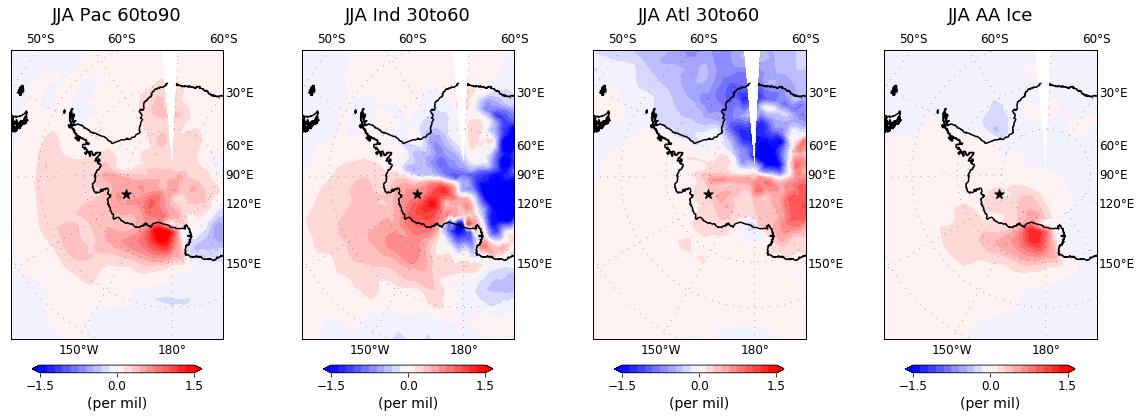

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6), sharex=True, sharey=True)

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,0.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,10)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

variable = jja_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0)-jja_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 1)
plt.title('JJA Pac 60to90',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


variable = jja_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0)-jja_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 2)
plt.title('JJA Ind 30to60',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


variable = jja_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0)-jja_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 3)
plt.title('JJA Atl 30to60',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


variable = jja_d18O_weighted_anoms_AA_ice_w_westmost_lons_ctrl.mean(axis=0)-jja_d18O_weighted_anoms_AA_ice_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 4)
plt.title('JJA AA Ice',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


plt.show()

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/wor

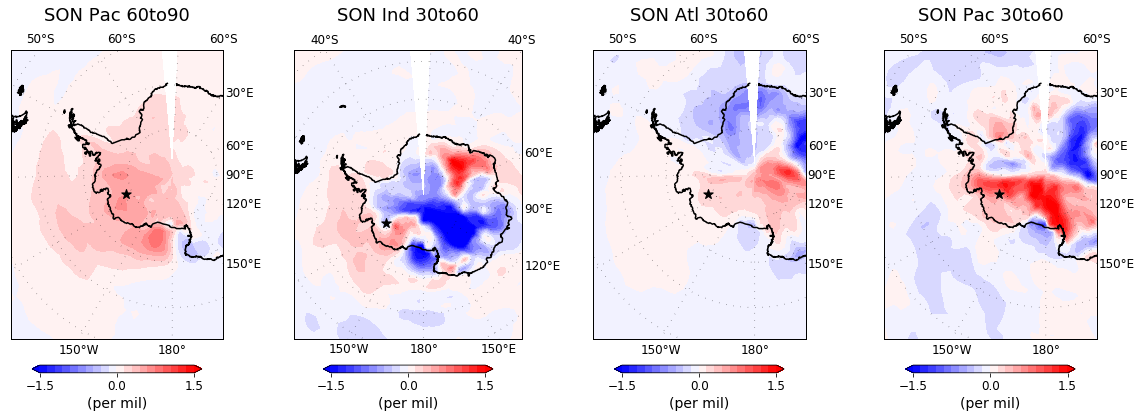

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6), sharex=True, sharey=True)

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,0.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,10)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

variable = son_d18O_weighted_anoms_Pac_60to90_w_westmost_lons_ctrl.mean(axis=0)-son_d18O_weighted_anoms_Pac_60to90_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 1)
plt.title('SON Pac 60to90',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


variable = son_d18O_weighted_anoms_Ind_30to60_w_westmost_lons_ctrl.mean(axis=0)-son_d18O_weighted_anoms_Ind_30to60_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 2)
plt.title('SON Ind 30to60',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=30,urcrnrlat=-40,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


variable = son_d18O_weighted_anoms_Atl_30to60_w_westmost_lons_ctrl.mean(axis=0)-son_d18O_weighted_anoms_Atl_30to60_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 3)
plt.title('SON Atl 30to60',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


variable = son_d18O_weighted_anoms_Pac_30to60_w_westmost_lons_ctrl.mean(axis=0)-son_d18O_weighted_anoms_Pac_30to60_w_eastmost_lons_ctrl.mean(axis=0)

plt.subplot(1, 4, 4)
plt.title('SON Pac 30to60',y=1.08,fontsize=18)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,variable,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(per mil)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)


plt.show()

In [59]:
#Relative CP Minimum Pressure Upper Quart vs Lower Quart; this would allow a tie to Hoskings et al and confirm my previous work

#Deep most is the lower quartile (deep has lower Rel CP values)
#Shallow most is the upper quartile (shallow has higher Rel CP values)

In [60]:
#create list of indices representing the shallowmost/deepmost quartiles of 'vals'
#Note, head is deepmost (sorted from low to high)
rel_cp_djf_mean_deepmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_djf_mean_deepmost_ctrl)
rel_cp_djf_mean_shallowmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_djf_mean_shallowmost_ctrl)

rel_cp_mam_mean_deepmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_mam_mean_deepmost_ctrl)
rel_cp_mam_mean_shallowmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_mam_mean_shallowmost_ctrl)

rel_cp_jja_mean_deepmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_jja_mean_deepmost_ctrl)
rel_cp_jja_mean_shallowmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_jja_mean_shallowmost_ctrl)

rel_cp_son_mean_deepmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_son_mean_deepmost_ctrl)
rel_cp_son_mean_shallowmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_son_mean_shallowmost_ctrl)

rel_cp_ann_mean_deepmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_ann_mean_deepmost_ctrl)
rel_cp_ann_mean_shallowmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_ann_mean_shallowmost_ctrl)

[23, 48, 30, 63, 5, 35, 60, 58, 6, 51, 39, 62, 20, 53, 65, 32, 50, 9]
[34, 45, 67, 26, 27, 18, 14, 12, 15, 68, 70, 37, 2, 64, 42, 49, 36, 71]
[64, 37, 38, 54, 70, 3, 46, 63, 47, 51, 10, 55, 49, 29, 16, 15, 36, 0, 73]
[41, 58, 59, 32, 27, 68, 21, 62, 42, 1, 19, 53, 45, 52, 14, 2, 56, 35, 31]
[17, 55, 49, 63, 19, 64, 56, 13, 37, 6, 24, 1, 11, 34, 59, 70, 3, 43, 58]
[23, 25, 22, 65, 27, 47, 39, 2, 40, 12, 7, 42, 30, 9, 52, 29, 28, 38, 41]
[67, 50, 15, 33, 43, 40, 5, 30, 21, 8, 71, 3, 9, 24, 70, 22, 14, 58, 2]
[61, 55, 66, 6, 1, 68, 13, 53, 17, 60, 56, 16, 62, 0, 26, 31, 34, 36, 46]
[64, 63, 37, 49, 8, 51, 3, 67, 70, 50, 18, 40, 24, 10, 22, 14, 54, 15, 19]
[45, 1, 34, 35, 41, 53, 5, 28, 42, 61, 62, 47, 2, 7, 39, 26, 74, 36, 69]


In [61]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_shallowmost_rel_cp_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_w_deepmost_rel_cp_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_djf_mean_deepmost_ctrl)
# djf_d18O_w_shallowmost_rel_cp_detrend_ctrl
# djf_d18O_w_deepmost_rel_cp_detrend_ctrl

#mam
mam_d18O_w_shallowmost_rel_cp_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_w_deepmost_rel_cp_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_mam_mean_deepmost_ctrl)
# mam_d18O_w_shallowmost_rel_cp_detrend_ctrl
# mam_d18O_w_deepmost_rel_cp_detrend_ctrl

#jja
jja_d18O_w_shallowmost_rel_cp_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_w_deepmost_rel_cp_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_jja_mean_deepmost_ctrl)
# jja_d18O_w_shallowmost_rel_cp_detrend_ctrl
# jja_d18O_w_deepmost_rel_cp_detrend_ctrl

#son
son_d18O_w_shallowmost_rel_cp_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_w_deepmost_rel_cp_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_w_shallowmost_rel_cp_detrend_ctrl
# son_d18O_w_deepmost_rel_cp_detrend_ctrl

#ann mean
ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = rel_cp_ann_mean_deepmost_ctrl)
# ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl
# ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl


In [62]:
#Select ASL Rel CP value, long, and lat while ASL Rel CP is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018

#djf
djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[rel_cp_djf_mean_shallowmost_ctrl]
# djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[rel_cp_djf_mean_deepmost_ctrl]
# djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#mam
mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[rel_cp_mam_mean_shallowmost_ctrl]
# mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[rel_cp_mam_mean_deepmost_ctrl]
# mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#jja
jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[rel_cp_jja_mean_shallowmost_ctrl]
# jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[rel_cp_jja_mean_deepmost_ctrl]
# jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#son
son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[rel_cp_son_mean_shallowmost_ctrl]
# son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[rel_cp_son_mean_deepmost_ctrl]
# son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[rel_cp_ann_mean_shallowmost_ctrl]
# ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[rel_cp_ann_mean_deepmost_ctrl]
# ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl

In [63]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_rel_cp_ttest_stats_ctrl, djf_d18O_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_shallowmost_rel_cp_detrend_ctrl, djf_d18O_w_deepmost_rel_cp_detrend_ctrl, axis=0)

mam_d18O_change_due_to_rel_cp_ttest_stats_ctrl, mam_d18O_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_shallowmost_rel_cp_detrend_ctrl, mam_d18O_w_deepmost_rel_cp_detrend_ctrl, axis=0)

jja_d18O_change_due_to_rel_cp_ttest_stats_ctrl, jja_d18O_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_shallowmost_rel_cp_detrend_ctrl, jja_d18O_w_deepmost_rel_cp_detrend_ctrl, axis=0)

son_d18O_change_due_to_rel_cp_ttest_stats_ctrl, son_d18O_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_shallowmost_rel_cp_detrend_ctrl, son_d18O_w_deepmost_rel_cp_detrend_ctrl, axis=0)

ann_mean_d18O_change_due_to_rel_cp_ttest_stats_ctrl, ann_mean_d18O_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl, ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl, axis=0)

### Before Plotting, going to calculate the d18O contributions from each Tagged region as well as the total d18O change from pseudoWDC

In [64]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_djf_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_mam_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_jja_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = rel_cp_son_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = rel_cp_ann_mean_deepmost_ctrl)

In [65]:
print('pseudoWDC DJF Rel CP Val. Deepmost =',np.round(djf_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF Rel CP Val. Diff =',np.round(djf_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA land DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA ice DJF Rel CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice DJF Rel CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice DJF Rel CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC MAM Rel CP Val. Deepmost =',np.round(mam_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM Rel CP Val. Diff =',np.round(mam_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA land MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA ice MAM Rel CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice MAM Rel CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice MAM Rel CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC JJA Rel CP Val. Deepmost =',np.round(jja_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA Rel CP Val. Diff =',np.round(jja_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA land JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA ice JJA Rel CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice JJA Rel CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice JJA Rel CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC SON Rel CP Val. Deepmost =',np.round(son_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON Rel CP Val. Shallowmost =',np.round(son_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON Rel CP Val. Diff =',np.round(son_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA land SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA ice SON Rel CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice SON Rel CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice SON Rel CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean Rel CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean Rel CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean Rel CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_rel_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_rel_cp_ctrl.mean(axis=0).values,2))

pseudoWDC DJF Rel CP Val. Deepmost = 4.11 , pseudoWDC DJF Rel CP Val. Shallowmost = 3.49 , pseudoWDC DJF Rel CP Val. Diff = 0.62
Atl 00to30 DJF Rel CP Val. Deepmost = 0.01 , Atl 00to30 DJF Rel CP Val. Shallowmost = -0.03 , Atl 00to30 DJF Rel CP Val. Diff = 0.04
Atl 30to60 DJF Rel CP Val. Deepmost = 0.07 , Atl 30to60 DJF Rel CP Val. Shallowmost = -0.06 , Atl 30to60 DJF Rel CP Val. Diff = 0.13
Atl 60to90 DJF Rel CP Val. Deepmost = -0.0 , Atl 60to90 DJF Rel CP Val. Shallowmost = 0.02 , Atl 60to90 DJF Rel CP Val. Diff = -0.02
Pac 00to30 DJF Rel CP Val. Deepmost = 0.03 , Pac 00to30 DJF Rel CP Val. Shallowmost = -0.02 , Pac 00to30 DJF Rel CP Val. Diff = 0.05
Pac 30to60 DJF Rel CP Val. Deepmost = -0.09 , Pac 30to60 DJF Rel CP Val. Shallowmost = -0.22 , Pac 30to60 DJF Rel CP Val. Diff = 0.13
Pac 60to90 DJF Rel CP Val. Deepmost = 0.06 , Pac 60to90 DJF Rel CP Val. Shallowmost = -0.02 , Pac 60to90 DJF Rel CP Val. Diff = 0.08
Ind 00to30 DJF Rel CP Val. Deepmost = -0.05 , Ind 00to30 DJF Rel CP Val.

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.343475470462206 -3.2413268975551484


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.246026599896219 -5.095320613268254


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-11.254362311686254 -6.666112397107685


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.550678565856293 -6.193335730519918


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.13736070831531 -4.775878872646911


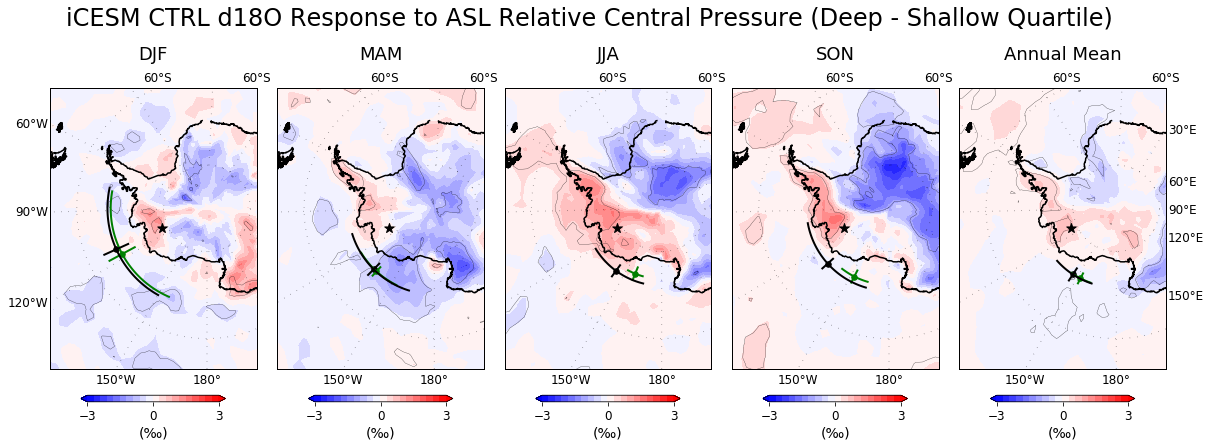

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Response to ASL Relative Central Pressure (Deep - Shallow Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-djf_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_mam = mam_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-mam_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_jja = jja_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-jja_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_son = son_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-son_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = addcyclic(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_sh, lons = addcyclic(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_sh, lons = addcyclic(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_sh, lons = addcyclic(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_sh, lons = addcyclic(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_djf_con, lons = addcyclic(djf_d18O_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_con, lons = addcyclic(mam_d18O_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_con, lons = addcyclic(jja_d18O_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_con, lons = addcyclic(son_d18O_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_con, lons = addcyclic(ann_mean_d18O_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-3,3.3,.3)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-djf_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((djf_d18O_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (djf_d18O_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-mam_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((mam_d18O_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (mam_d18O_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-jja_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((jja_d18O_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (jja_d18O_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-son_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((son_d18O_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (son_d18O_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_d18O_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((ann_mean_d18O_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_d18O_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Field_vs_ASL_Rel_CP_Values_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [67]:
#Absolute CP Minimum Pressure Upper Quart vs Lower Quart; this would allow a tie to Hoskings et al and confirm my previous work
Abs_CP_djf_mean_indices_raw_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_djf_mean_indices_raw_ctrl.vals + Rel_CP_djf_mean_indices_raw_ctrl.sectormean))
Abs_CP_djf_mean_indices_raw_ctrl
Abs_CP_mam_mean_indices_raw_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_mam_mean_indices_raw_ctrl.vals + Rel_CP_mam_mean_indices_raw_ctrl.sectormean))
Abs_CP_mam_mean_indices_raw_ctrl
Abs_CP_jja_mean_indices_raw_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_jja_mean_indices_raw_ctrl.vals + Rel_CP_jja_mean_indices_raw_ctrl.sectormean))
Abs_CP_jja_mean_indices_raw_ctrl
Abs_CP_son_mean_indices_raw_ctrl = Rel_CP_son_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_son_mean_indices_raw_ctrl.vals + Rel_CP_son_mean_indices_raw_ctrl.sectormean))
Abs_CP_son_mean_indices_raw_ctrl
Abs_CP_ann_mean_indices_raw_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_ann_mean_indices_raw_ctrl.vals + Rel_CP_ann_mean_indices_raw_ctrl.sectormean))
Abs_CP_ann_mean_indices_raw_ctrl
#Deep most is the lower quartile (deep has lower Abs CP values)
#Shallow most is the upper quartile (shallow has higher Abs CP values)

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1702-01-01,-5.477830,-71.052632,197.5,986.772813,0,981.294983
1703-01-01,-5.095673,-71.052632,195.0,989.296173,1,984.200500
1704-01-01,-4.715917,-71.052632,205.0,989.053075,2,984.337158
1705-01-01,-7.214285,-71.052632,205.0,987.087820,3,979.873535
1706-01-01,-6.000570,-71.052632,207.5,982.878988,4,976.878418
1707-01-01,-5.013147,-72.947368,202.5,988.179468,5,983.166321
1708-01-01,-6.237241,-72.947368,200.0,986.348752,6,980.111511
1709-01-01,-4.708475,-74.842105,202.5,985.381021,7,980.672546
1710-01-01,-7.355555,-71.052632,212.5,983.823085,8,976.467529


In [68]:
#create list of indices representing the shallowmost/deepmost quartiles of 'abs_vals'
#Note, head is deepmost (sorted from low to high)
abs_cp_djf_mean_deepmost_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_djf_mean_deepmost_ctrl)
abs_cp_djf_mean_shallowmost_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_djf_mean_shallowmost_ctrl)

abs_cp_mam_mean_deepmost_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_mam_mean_deepmost_ctrl)
abs_cp_mam_mean_shallowmost_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_mam_mean_shallowmost_ctrl)

abs_cp_jja_mean_deepmost_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_jja_mean_deepmost_ctrl)
abs_cp_jja_mean_shallowmost_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_jja_mean_shallowmost_ctrl)

abs_cp_son_mean_deepmost_ctrl = Abs_CP_son_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_son_mean_deepmost_ctrl)
abs_cp_son_mean_shallowmost_ctrl = Abs_CP_son_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_son_mean_shallowmost_ctrl)

abs_cp_ann_mean_deepmost_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_ann_mean_deepmost_ctrl)
abs_cp_ann_mean_shallowmost_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_ann_mean_shallowmost_ctrl)

[59, 9, 51, 62, 53, 63, 13, 14, 72, 54, 46, 10, 25, 61, 43, 35, 50, 47]
[0, 69, 42, 56, 30, 41, 68, 55, 31, 49, 29, 27, 2, 12, 44, 38, 36, 71]
[64, 38, 70, 4, 54, 10, 8, 11, 55, 29, 36, 47, 3, 34, 46, 37, 15, 7, 0]
[41, 16, 60, 27, 35, 57, 19, 14, 32, 1, 59, 5, 45, 20, 56, 2, 30, 61, 31]
[17, 14, 70, 13, 63, 37, 64, 50, 24, 21, 61, 34, 66, 59, 18, 49, 72, 6, 62]
[30, 0, 47, 27, 31, 1, 7, 44, 22, 32, 19, 43, 12, 52, 65, 38, 16, 2, 41]
[43, 14, 38, 21, 50, 9, 8, 48, 69, 20, 51, 53, 29, 10, 22, 57, 58, 37, 54]
[46, 60, 6, 7, 17, 65, 39, 34, 55, 68, 5, 74, 71, 0, 44, 31, 1, 26, 36]
[14, 64, 10, 50, 9, 8, 54, 63, 4, 18, 70, 51, 21, 37, 72, 29, 11, 62, 15]
[35, 61, 0, 65, 19, 16, 69, 71, 56, 44, 39, 74, 41, 36, 30, 5, 1, 2, 31]


In [69]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_shallowmost_abs_cp_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_w_deepmost_abs_cp_detrend_ctrl = djf_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_djf_mean_deepmost_ctrl)
# djf_d18O_w_shallowmost_abs_cp_detrend_ctrl
# djf_d18O_w_deepmost_abs_cp_detrend_ctrl

#mam
mam_d18O_w_shallowmost_abs_cp_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_w_deepmost_abs_cp_detrend_ctrl = mam_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_mam_mean_deepmost_ctrl)
# mam_d18O_w_shallowmost_abs_cp_detrend_ctrl
# mam_d18O_w_deepmost_abs_cp_detrend_ctrl

#jja
jja_d18O_w_shallowmost_abs_cp_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_w_deepmost_abs_cp_detrend_ctrl = jja_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_jja_mean_deepmost_ctrl)
# jja_d18O_w_shallowmost_abs_cp_detrend_ctrl
# jja_d18O_w_deepmost_abs_cp_detrend_ctrl

#son
son_d18O_w_shallowmost_abs_cp_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_w_deepmost_abs_cp_detrend_ctrl = son_d18O_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_w_shallowmost_abs_cp_detrend_ctrl
# son_d18O_w_deepmost_abs_cp_detrend_ctrl

#ann mean
ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl = d18O_shem_ann_mean_detrend_ctrl.isel(time = abs_cp_ann_mean_deepmost_ctrl)
# ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl
# ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl


In [70]:
#Select ASL Abs CP value, long, and lat while ASL Abs CP is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018

#djf
djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.iloc[abs_cp_djf_mean_shallowmost_ctrl]
# djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.iloc[abs_cp_djf_mean_deepmost_ctrl]
# djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#mam
mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.iloc[abs_cp_mam_mean_shallowmost_ctrl]
# mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.iloc[abs_cp_mam_mean_deepmost_ctrl]
# mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#jja
jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.iloc[abs_cp_jja_mean_shallowmost_ctrl]
# jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.iloc[abs_cp_jja_mean_deepmost_ctrl]
# jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#son
son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_son_mean_indices_raw_ctrl.iloc[abs_cp_son_mean_shallowmost_ctrl]
# son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_son_mean_indices_raw_ctrl.iloc[abs_cp_son_mean_deepmost_ctrl]
# son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#annual mean
ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.iloc[abs_cp_ann_mean_shallowmost_ctrl]
# ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.iloc[abs_cp_ann_mean_deepmost_ctrl]
# ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl

In [71]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_d18O_change_due_to_abs_cp_ttest_stats_ctrl, djf_d18O_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_shallowmost_abs_cp_detrend_ctrl, djf_d18O_w_deepmost_abs_cp_detrend_ctrl, axis=0)

mam_d18O_change_due_to_abs_cp_ttest_stats_ctrl, mam_d18O_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    mam_d18O_w_shallowmost_abs_cp_detrend_ctrl, mam_d18O_w_deepmost_abs_cp_detrend_ctrl, axis=0)

jja_d18O_change_due_to_abs_cp_ttest_stats_ctrl, jja_d18O_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_shallowmost_abs_cp_detrend_ctrl, jja_d18O_w_deepmost_abs_cp_detrend_ctrl, axis=0)

son_d18O_change_due_to_abs_cp_ttest_stats_ctrl, son_d18O_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    son_d18O_w_shallowmost_abs_cp_detrend_ctrl, son_d18O_w_deepmost_abs_cp_detrend_ctrl, axis=0)

ann_mean_d18O_change_due_to_abs_cp_ttest_stats_ctrl, ann_mean_d18O_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl, ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl, axis=0)

### Before Plotting, going to calculate the d18O contributions from each Tagged region as well as the total d18O change from pseudoWDC

In [72]:
#Select d18O weighted anoms for each tagged region and psuedoWDC record while index is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018
#djf
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl = djf_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_djf_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl = mam_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_mam_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl = jja_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_jja_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl = son_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(time = abs_cp_son_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Atl_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Pac_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_00to30_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_30to60_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_Ind_60to90_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_land_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl = ann_mean_d18O_weighted_anoms_AA_ice_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').isel(year = abs_cp_ann_mean_deepmost_ctrl)

In [73]:
print('pseudoWDC DJF Abs CP Val. Deepmost =',np.round(djf_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC DJF Abs CP Val. Diff =',np.round(djf_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - djf_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA land DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA ice DJF Abs CP Val. Deepmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice DJF Abs CP Val. Shallowmost =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice DJF Abs CP Val. Diff =',np.round(djf_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values - djf_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC MAM Abs CP Val. Deepmost =',np.round(mam_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC MAM Abs CP Val. Diff =',np.round(mam_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - mam_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA land MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA ice MAM Abs CP Val. Deepmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice MAM Abs CP Val. Shallowmost =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice MAM Abs CP Val. Diff =',np.round(mam_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values - mam_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC JJA Abs CP Val. Deepmost =',np.round(jja_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC JJA Abs CP Val. Diff =',np.round(jja_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - jja_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA land JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA ice JJA Abs CP Val. Deepmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice JJA Abs CP Val. Shallowmost =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice JJA Abs CP Val. Diff =',np.round(jja_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values - jja_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC SON Abs CP Val. Deepmost =',np.round(son_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON Abs CP Val. Shallowmost =',np.round(son_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC SON Abs CP Val. Diff =',np.round(son_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - son_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA land SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA ice SON Abs CP Val. Deepmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice SON Abs CP Val. Shallowmost =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice SON Abs CP Val. Diff =',np.round(son_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values - son_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('pseudoWDC Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2),
      ', pseudoWDC Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values - ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').mean(axis=0).values,2))
print('Atl 00to30 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 00to30 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 30to60 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 30to60 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Atl 60to90 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Atl 60to90 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Atl_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 00to30 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 00to30 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 30to60 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 30to60 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Pac 60to90 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Pac 60to90 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Pac_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 00to30 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 00to30 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_00to30_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 30to60 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 30to60 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_30to60_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('Ind 60to90 Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', Ind 60to90 Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_Ind_60to90_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA land Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA land Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_land_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))
print('AA ice Ann Mean Abs CP Val. Deepmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean Abs CP Val. Shallowmost =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2),
      ', AA ice Ann Mean Abs CP Val. Diff =',np.round(ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_deepmost_abs_cp_ctrl.mean(axis=0).values - ann_mean_d18O_weighted_anoms_at_WDC_AA_ice_w_shallowmost_abs_cp_ctrl.mean(axis=0).values,2))

pseudoWDC DJF Abs CP Val. Deepmost = 3.67 , pseudoWDC DJF Abs CP Val. Shallowmost = 4.26 , pseudoWDC DJF Abs CP Val. Diff = -0.59
Atl 00to30 DJF Abs CP Val. Deepmost = 0.03 , Atl 00to30 DJF Abs CP Val. Shallowmost = 0.03 , Atl 00to30 DJF Abs CP Val. Diff = 0.01
Atl 30to60 DJF Abs CP Val. Deepmost = 0.02 , Atl 30to60 DJF Abs CP Val. Shallowmost = 0.08 , Atl 30to60 DJF Abs CP Val. Diff = -0.06
Atl 60to90 DJF Abs CP Val. Deepmost = -0.04 , Atl 60to90 DJF Abs CP Val. Shallowmost = 0.04 , Atl 60to90 DJF Abs CP Val. Diff = -0.08
Pac 00to30 DJF Abs CP Val. Deepmost = 0.01 , Pac 00to30 DJF Abs CP Val. Shallowmost = -0.2 , Pac 00to30 DJF Abs CP Val. Diff = 0.21
Pac 30to60 DJF Abs CP Val. Deepmost = -0.14 , Pac 30to60 DJF Abs CP Val. Shallowmost = 0.01 , Pac 30to60 DJF Abs CP Val. Diff = -0.16
Pac 60to90 DJF Abs CP Val. Deepmost = -0.12 , Pac 60to90 DJF Abs CP Val. Shallowmost = 0.07 , Pac 60to90 DJF Abs CP Val. Diff = -0.19
Ind 00to30 DJF Abs CP Val. Deepmost = 0.09 , Ind 00to30 DJF Abs CP Val.

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.118641018182643 -3.992495510059194


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.040834334778268 -5.6198640739965136


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-10.292312878658716 -7.818354395821936


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-8.548291691523445 -6.740404232116134


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.72520804969457 -5.205050146763352


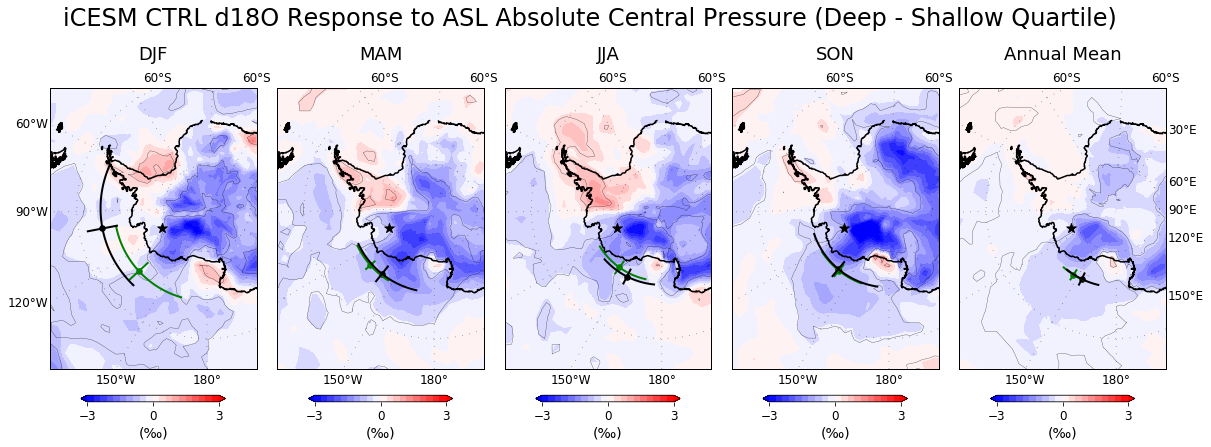

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Response to ASL Absolute Central Pressure (Deep - Shallow Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-djf_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_mam = mam_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-mam_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_jja = jja_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-jja_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_son = son_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-son_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = addcyclic(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_sh, lons = addcyclic(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_sh, lons = addcyclic(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_sh, lons = addcyclic(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_sh, lons = addcyclic(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_djf_con, lons = addcyclic(djf_d18O_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_mam_con, lons = addcyclic(mam_d18O_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_jja_con, lons = addcyclic(jja_d18O_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_son_con, lons = addcyclic(son_d18O_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
diff_ann_con, lons = addcyclic(ann_mean_d18O_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-3,3.3,.3)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-djf_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((djf_d18O_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (djf_d18O_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-mam_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((mam_d18O_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (mam_d18O_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-jja_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((jja_d18O_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (jja_d18O_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-son_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((son_d18O_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (son_d18O_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_d18O_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-ann_mean_d18O_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((ann_mean_d18O_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_d18O_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('(‰)',size=14)
cbar.set_ticks([-3, 0, 3])
cbar.ax.tick_params(labelsize=12)
plt.clim([-3,3])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Field_vs_ASL_Abs_CP_Values_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

# Stopped here with addcylic; just need to make changes in the plotting cells
# Old file includes PDO, EPC1, EPC2, SOI, ENSO3.4